<b>Описание проекта</b>

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

<b>Цель исследования</b>

- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

<b>План первого исследования</b>

- загрузка и изучение предоставленных данных
- предобработка данных
- исследовательский анализ данных
- подготовка данных для МО
- обучение моделей
- выводы

<b>Описание данных для первого исследования.</b>

<b>id</b> — уникальный идентификатор сотрудника;

<b>dept</b> — отдел, в котором работает сотрудник;

<b>level</b> — уровень занимаемой должности;

<b>workload</b> — уровень загруженности сотрудника;

<b>employment_years</b> — длительность работы в компании (в годах);

<b>last_year_promo</b> — показывает, было ли повышение за последний год;

<b>last_year_violations</b> — показывает, нарушал ли сотрудник трудовой договор за последний год;

<b>supervisor_evaluation</b> — оценка качества работы сотрудника, которую дал руководитель;

<b>salary</b> — ежемесячная зарплата сотрудника;

<b>job_satisfaction_rate</b> — уровень удовлетворённости сотрудника работой в компании, <b>(целевой признак)</b>.


<b>План второго исследования</b>

- загрузка и изучение предоставленных данных
- предобработка данных
- исследовательский анализ данных
- внесение новых признаков 
- подготовка данных для МО
- обучение модели
- выводы

<b>Описание данных для второго исследования.</b>

- Тренировочная выборка: train_quit.csv
- Входные признаки тестовой выборки те же, что и в прошлой задаче:test_features.csv
- Целевой признак тестовой выборки:test_target_quit.csv

<b>id</b> — уникальный идентификатор сотрудника;

<b>dept</b> — отдел, в котором работает сотрудник;

<b>level</b> — уровень занимаемой должности;

<b>workload</b> — уровень загруженности сотрудника;

<b>employment_years</b> — длительность работы в компании (в годах);

<b>last_year_promo</b> — показывает, было ли повышение за последний год;

<b>last_year_violations</b> — показывает, нарушал ли сотрудник трудовой договор за последний год;

<b>supervisor_evaluation</b> — оценка качества работы сотрудника, которую дал руководитель;

<b>salary</b> — ежемесячная зарплата сотрудника;

<b>quit</b> — факт увольнения сотрудника из компании <b>(целевой признак)</b>.

<b>Предсказание уровеня удовлетворённости сотрудника</b>

In [1]:
!pip install phik
!pip install shap
!pip install lightgbm
!pip install -U scikit-learn

In [2]:
import warnings
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.dummy import DummyClassifier
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

<b>Загрузка и изучение предоставленных данных</b>

In [3]:
X_train_data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test_features_data = pd.read_csv('/datasets/test_features.csv')
y_test_data = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
def pretty_display(df, title="Таблица"):
    styled_df = df.head(5).style \
        .set_table_styles(
            [{'selector': 'th', 'props': [('text-align', 'center')]}]
        ) \
        .set_properties(**{'text-align': 'center'}) \
        .highlight_null(null_color='lightgray') \
        .set_caption(title)
    
    display(styled_df)

In [5]:
pretty_display(X_train_data, "Первые 5 строк таблицы X_train_data")
pretty_display(X_test_features_data, "Первые 5 строк таблицы X_test_features_data")
pretty_display(y_test_data, "Первые 5 строк таблицы y_test_data")

Столбцы имеют правильное название, без ошибок и преведены к единому формату, следовательно их не надо переименовывать.

In [6]:
display(X_train_data.info())
display(X_test_features_data.info())
display(y_test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Тренировочные данные и тестовые имеют одинаковые типы, нет нужды их преобрвзовывать.

<b>Проверка файлов на наличие дубликатов</b>

In [7]:
def check_duplicates(df, name):
    dup_count = df.duplicated().sum()
    print(f"В {name}: {dup_count} дубликатов")
    if dup_count > 0:
        print(df[df.duplicated()].head())
    print('-' * 50)

In [8]:
missing_values = X_train_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values
check_duplicates(X_train_data, "X_train_data")
X_train_data = X_train_data.drop_duplicates().reset_index(drop=True)

В X_train_data: 0 дубликатов
--------------------------------------------------


В файле train_job_satisfaction_rate не обнаружено явных дубликатов.

In [9]:
missing_values = X_test_features_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values
check_duplicates(X_test_features_data, "X_test_features_data")
X_test_features_data = X_test_features_data.drop_duplicates().reset_index(drop=True)

В X_test_features_data: 0 дубликатов
--------------------------------------------------


В файле test_features не обнаружено явных дубликатов.

In [10]:
missing_values = y_test_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values
check_duplicates(y_test_data, "y_test_data")
y_test_data = y_test_data.drop_duplicates().reset_index(drop=True)

В y_test_data: 0 дубликатов
--------------------------------------------------


В файле test_target_job_satisfaction_rate не обнаружено явных дубликатов.

<b>Проверка файлов на наличие пропусков</b>

In [11]:
print(X_train_data.isnull().sum())
print(X_test_features_data.isnull().sum())
print(y_test_data.isnull().sum())

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
id                       0
job_satisfaction_rate    0
dtype: int64


- В файле X_train_data есть 6 пропусков в столбце dept и 4 пропуска в столбце level.

- В файле X_test_features_data есть 2 пропуска в столбце dept и 1 пропуск в столбце level.

Решено заполнить пропуска в обоих файлах при помощи пайплайна, на этапе МО.

<b>Проверка на наличие ошибок с строковых значениях</b>

In [12]:
unique_values_dict = {
    column: list(X_train_data[column].unique())
    for column in X_train_data.columns
    if X_train_data[column].dtype == 'object'
}
print(unique_values_dict)

{'dept': ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan], 'level': ['junior', 'middle', 'sinior', nan], 'workload': ['medium', 'high', 'low'], 'last_year_promo': ['no', 'yes'], 'last_year_violations': ['no', 'yes']}


In [13]:
X_train_data['level'].replace({'sinior': 'senior'}, inplace=True)
print(X_train_data['level'].unique())

['junior' 'middle' 'senior' nan]


В столбце level файла X_train_data была найдена орфографическая ошибка, решено исправить ее.

In [14]:
unique_values_dict = {
    column: list(X_test_features_data[column].unique())
    for column in X_test_features_data.columns
    if X_test_features_data[column].dtype == 'object'
}
print(unique_values_dict)

{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '], 'level': ['junior', 'middle', 'sinior', nan], 'workload': ['medium', 'low', 'high', ' '], 'last_year_promo': ['no', 'yes'], 'last_year_violations': ['no', 'yes']}


In [15]:
X_test_features_data['level'].replace({'sinior': 'senior'}, inplace=True)
X_test_features_data['dept'].replace({' ': np.nan}, inplace=True)
X_test_features_data['workload'].replace({' ': np.nan}, inplace=True)

In [16]:
unique_values_dict = {
    column: list(X_test_features_data[column].unique())
    for column in X_test_features_data.columns
    if X_test_features_data[column].dtype == 'object'
}
print(unique_values_dict)

{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan], 'level': ['junior', 'middle', 'senior', nan], 'workload': ['medium', 'low', 'high', nan], 'last_year_promo': ['no', 'yes'], 'last_year_violations': ['no', 'yes']}


В столбце level файла X_test_features_data была найдена аналогичная орфографическая ошибка, решено исправить ее.

Также выявлены значение заполненные пробелом в столбцах dept и workload, решено заменить их на nan.

In [17]:
y_test_data['job_satisfaction_rate'].unique()

array([0.74, 0.75, 0.6 , 0.72, 0.08, 0.76, 0.64, 0.38, 0.14, 0.59, 0.91,
       0.78, 0.7 , 0.79, 0.34, 0.81, 0.23, 0.4 , 0.58, 0.77, 0.68, 0.24,
       0.42, 0.69, 0.47, 0.35, 0.71, 0.83, 0.61, 0.65, 0.37, 0.45, 0.63,
       0.82, 0.16, 0.89, 0.28, 0.32, 0.88, 0.36, 0.33, 0.31, 0.27, 0.73,
       0.53, 0.26, 0.57, 0.2 , 1.  , 0.56, 0.67, 0.19, 0.52, 0.43, 0.12,
       0.11, 0.21, 0.13, 0.49, 0.22, 0.86, 0.46, 0.41, 0.48, 0.29, 0.87,
       0.66, 0.8 , 0.55, 0.5 , 0.51, 0.62, 0.85, 0.84, 0.15, 0.39, 0.25,
       0.9 , 0.07, 0.1 , 0.92, 0.3 , 0.44, 0.18, 0.93, 0.54, 0.96, 0.09,
       0.99, 0.17, 0.95, 0.06, 0.94, 0.03, 0.98, 0.97, 0.04, 0.05])

В файле y_test_data не обнаружено никаких ошибок или аномальных значений.

<b>Вывод по предобработке данных</b>

- В целом файл не имел значительных изъянов, было исправлена орфографическая ошибка в одном столбце. также строки где присутствовали пробелы были заполнены на nan, были удалены пропуска. 

<b>Исследовательский анализ данных</b>

In [18]:
def plot_numeric_features(df, features=None, bins=30):
  
    if features is None:
        features = df.select_dtypes(include='number').columns
    
    for col in features:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), bins=bins, kde=True, color='skyblue')
        plt.title(f'Распределение признака: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f'Boxplot признака: {col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()
        
def plot_categorical_pie_charts(df, features=None, max_categories=10, include_na=True, autopct='%1.1f%%'):

    if features is None:
        features = df.select_dtypes(include='object').columns

    for col in features:
        value_counts = df[col].value_counts(dropna=not include_na)

        if len(value_counts) > max_categories:
            print(f"Пропущено '{col}' — слишком много уникальных значений ({len(value_counts)})")
            continue

        labels = value_counts.index.astype(str)
        sizes = value_counts.values
        plt.figure(figsize=(6, 6))
        plt.pie(sizes, labels=labels, autopct=autopct, startangle=90, counterclock=False)
        plt.title(f'Круговая диаграмма: {col}')
        plt.axis('equal')  # чтобы круг был кругом, а не овалом
        plt.tight_layout()
        plt.show()

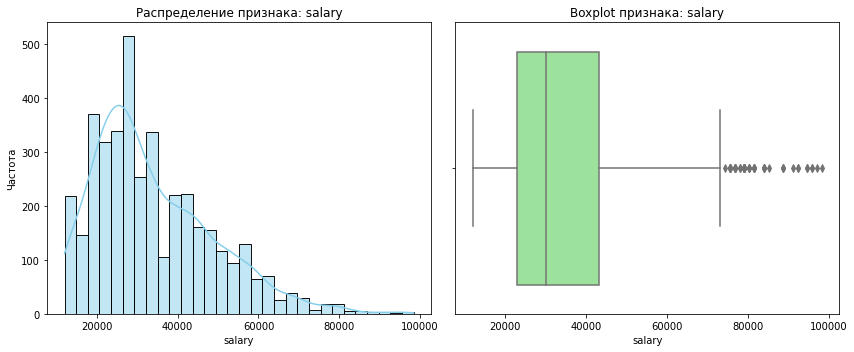

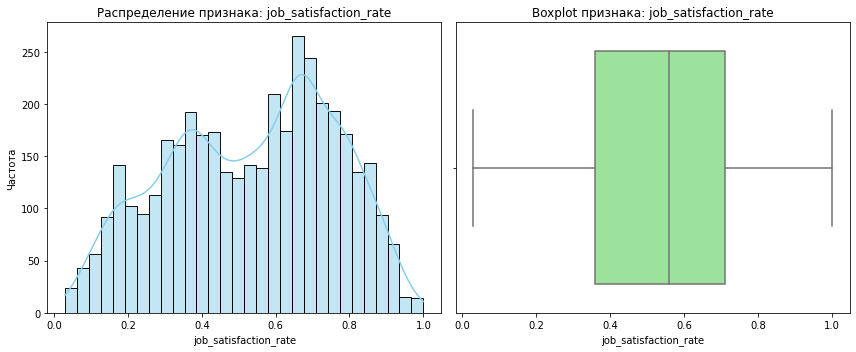

In [19]:
X_train_data_with_no_id = X_train_data.drop(['id', 'employment_years', 'supervisor_evaluation'], axis=1)

plot_numeric_features(X_train_data_with_no_id)

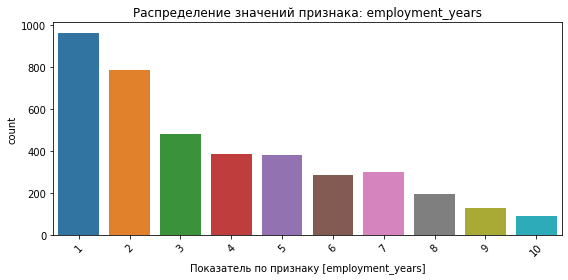

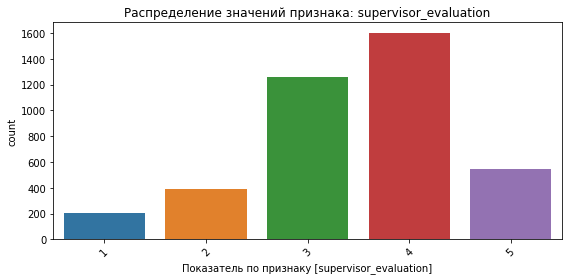

In [20]:
def plot_countplots(df, columns, figsize=(8, 4)):
    for col in columns:
        plt.figure(figsize=figsize)
        sns.countplot(x=df[col])
        plt.xlabel(f'Показатель по признаку [{col}]')
        plt.title(f'Распределение значений признака: {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
columns_to_plot = [
    'employment_years',
    'supervisor_evaluation',
]

plot_countplots(X_train_data, columns_to_plot)

<b>Промежуточный вывод по исследовательскому анализу</b>
- В столбце salary (зарплата), имеется большое количество высоких значений, видимо это зарплаты топовых менеджеров, удалять их не стоит из за того что это не ошибка сбора данных.

- В столбце job_satisfaction_rate, нет аномальных значений, медиана находиться на уровне 0.58 баллов из 1.0

- Столбец employment_years показывает что большинство сотрудников работают в компании 1-2 года. Значения распределены нормально.

- Столбец supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель. Большинство получают 3-4 балла из 5.

В количественных признаках X_train_data не найдено аномальных значений. Данные готовы для задач МО.

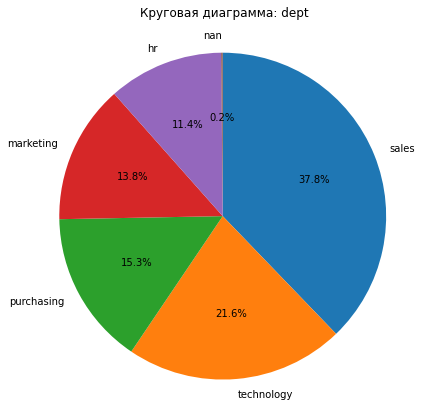

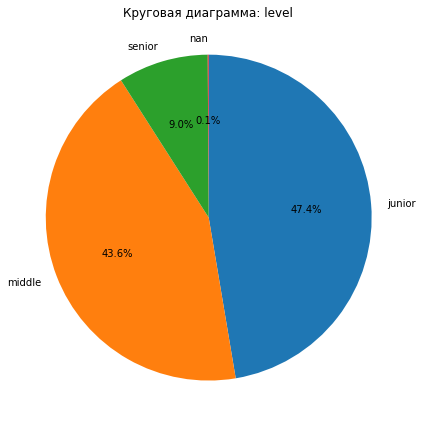

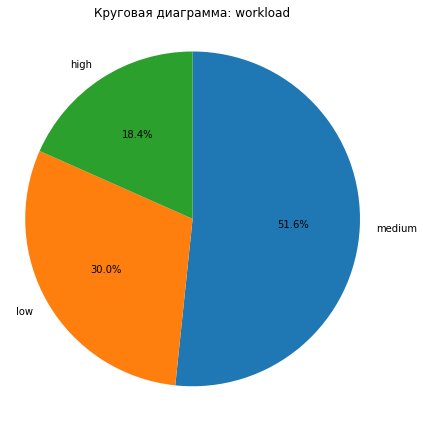

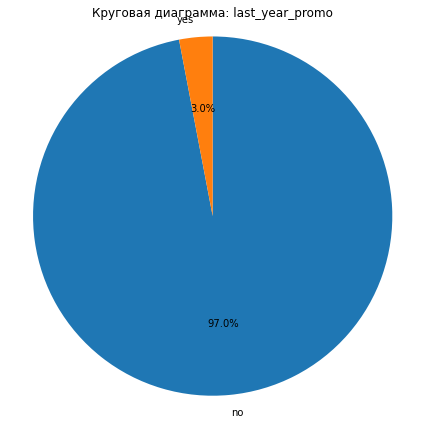

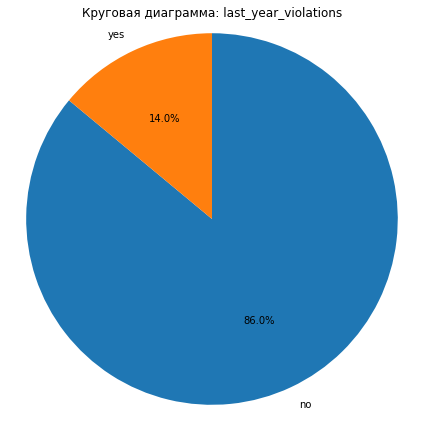

In [21]:
plot_categorical_pie_charts(X_train_data_with_no_id)

- Визуализация категориальных признаков показало что некоторые столбцы имеют дисбаланс значений, last_year_violations и last_year_promo. В целом при подготовке данных к обучения стоит учесть несбалансированность признаков.

In [22]:
df_no_id = X_train_data.drop(columns=['id'])

# Задаём список непрерывных переменных
interval_columns = [
    'salary',
    'job_satisfaction_rate',
]

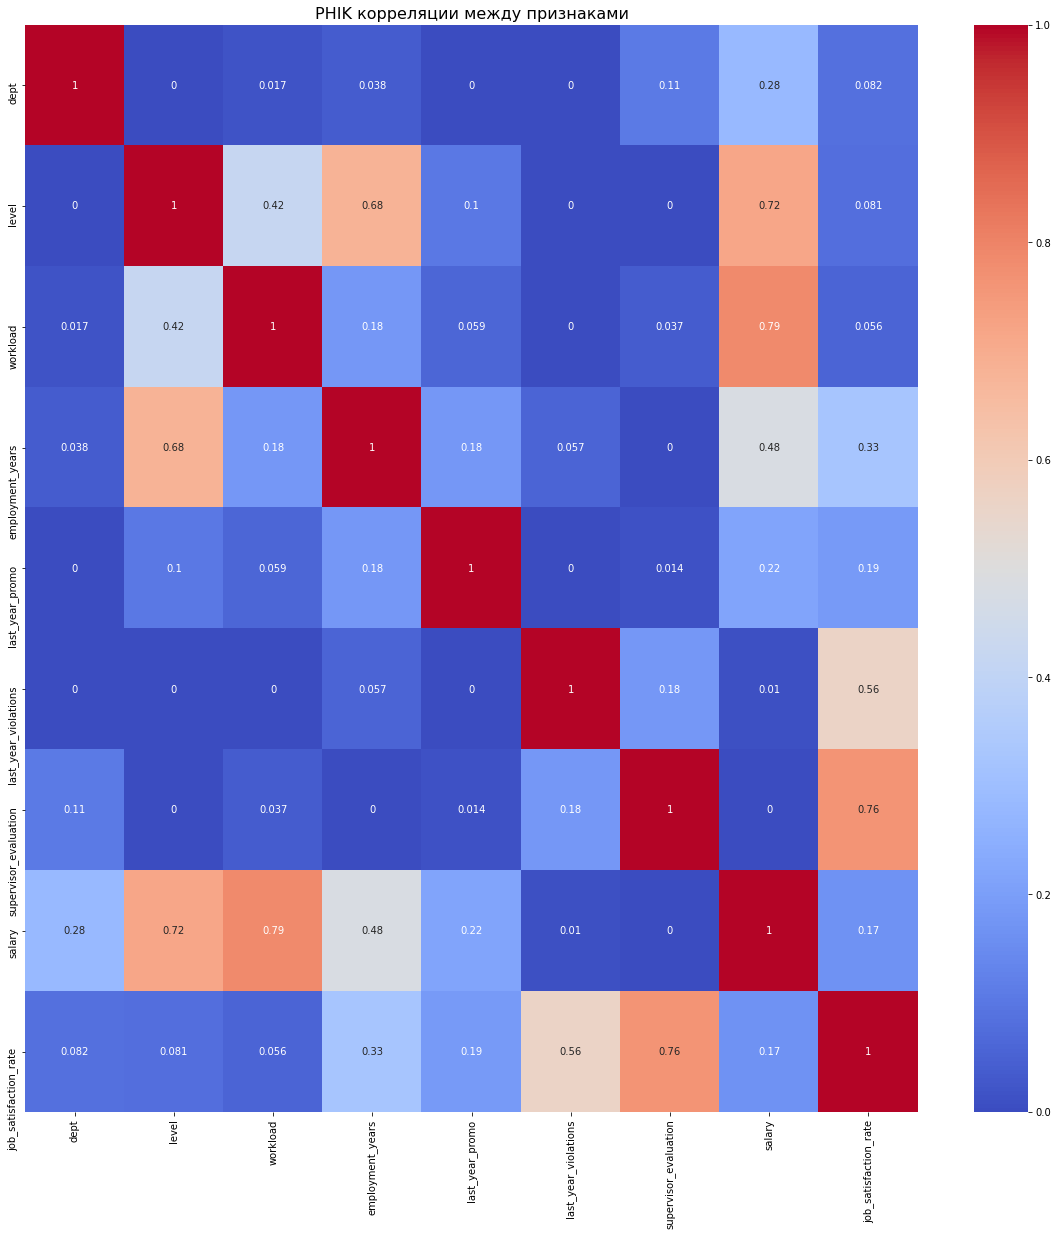

In [23]:
# Вычисляем phik-корреляции с указанием непрерывных переменных
phik_corr = df_no_id.phik_matrix(interval_cols=interval_columns)

# Визуализация
plt.figure(figsize=(20, 20))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm')
plt.title("PHIK корреляции между признаками", fontsize=16)
plt.show()

С целевым признаком job_satisfaction_rate коррелирует такие признаки как: 
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель (0.76);

- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год (0.56);

- employment_years — длительность работы в компании (в годах) (0.33);

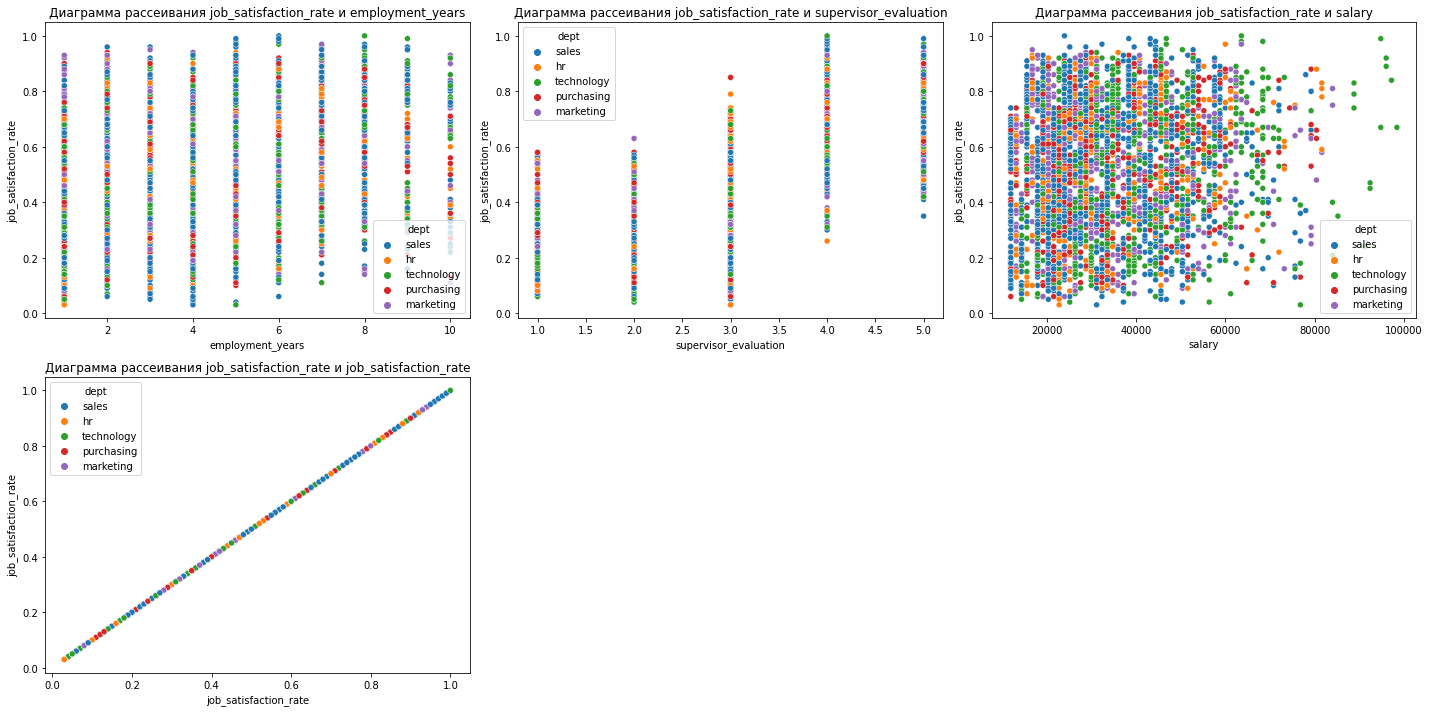

In [24]:
# Создадим список количественных признаков 
quantitative_array = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=X_train_data, x=feature, y='job_satisfaction_rate', hue='dept')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

- Анализ количественных и категориальных признаков показал что на удовлетворенность работой (job_satisfaction_rate) сильнее всего влияет (supervisor_evaluation) — т.е качества работы сотрудника, которую дал руководитель.

Отдел в котором работает сотрудник не показал какую либо зависимость с целевым признаком (job_satisfaction_rate)

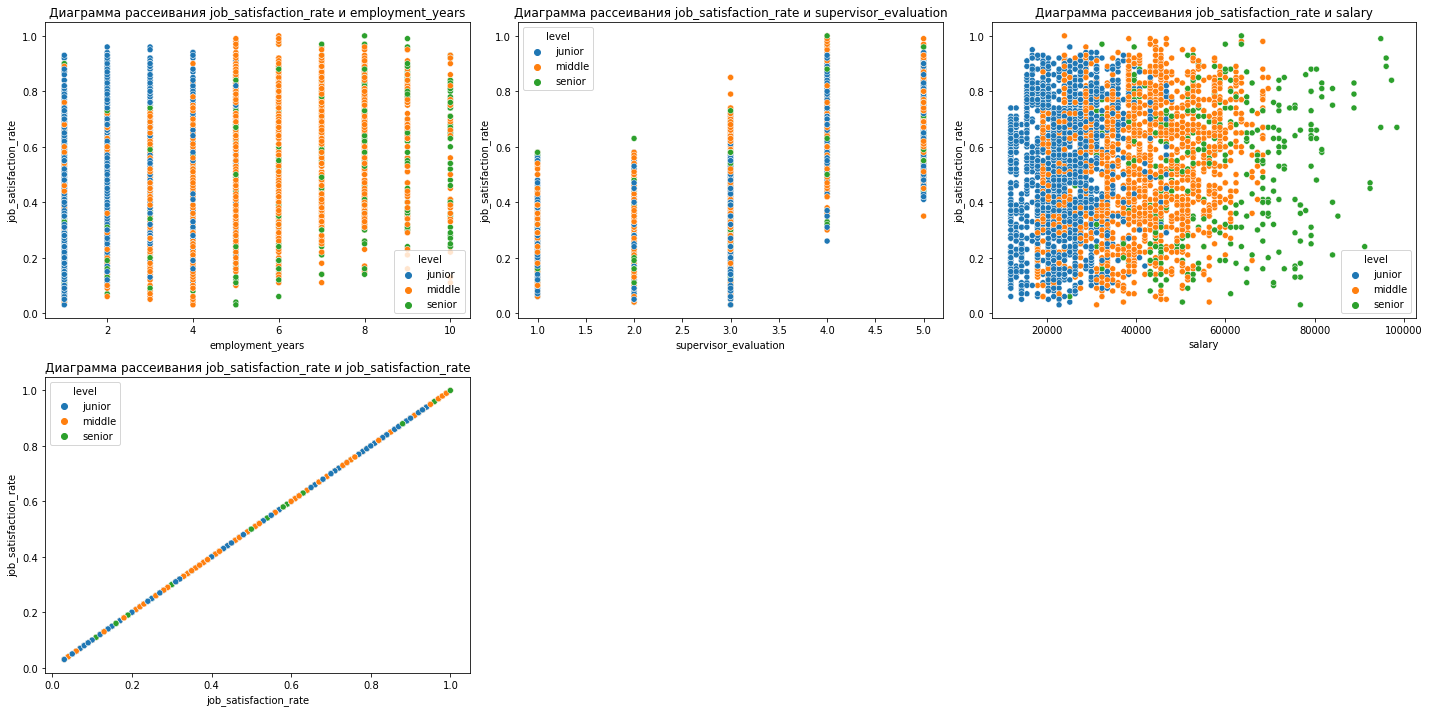

In [25]:
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=X_train_data, x=feature, y='job_satisfaction_rate', hue='level')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

Есть слабая зависимость между целевым признаком (job_satisfaction_rate) и employment_years. 
визуализация показала что все junior сотрудники работают в компании с основном от 1 года до 3, (реже до 4 лет), потом они уходят на повышение и их средняя оценка job_satisfaction_rate повышается.

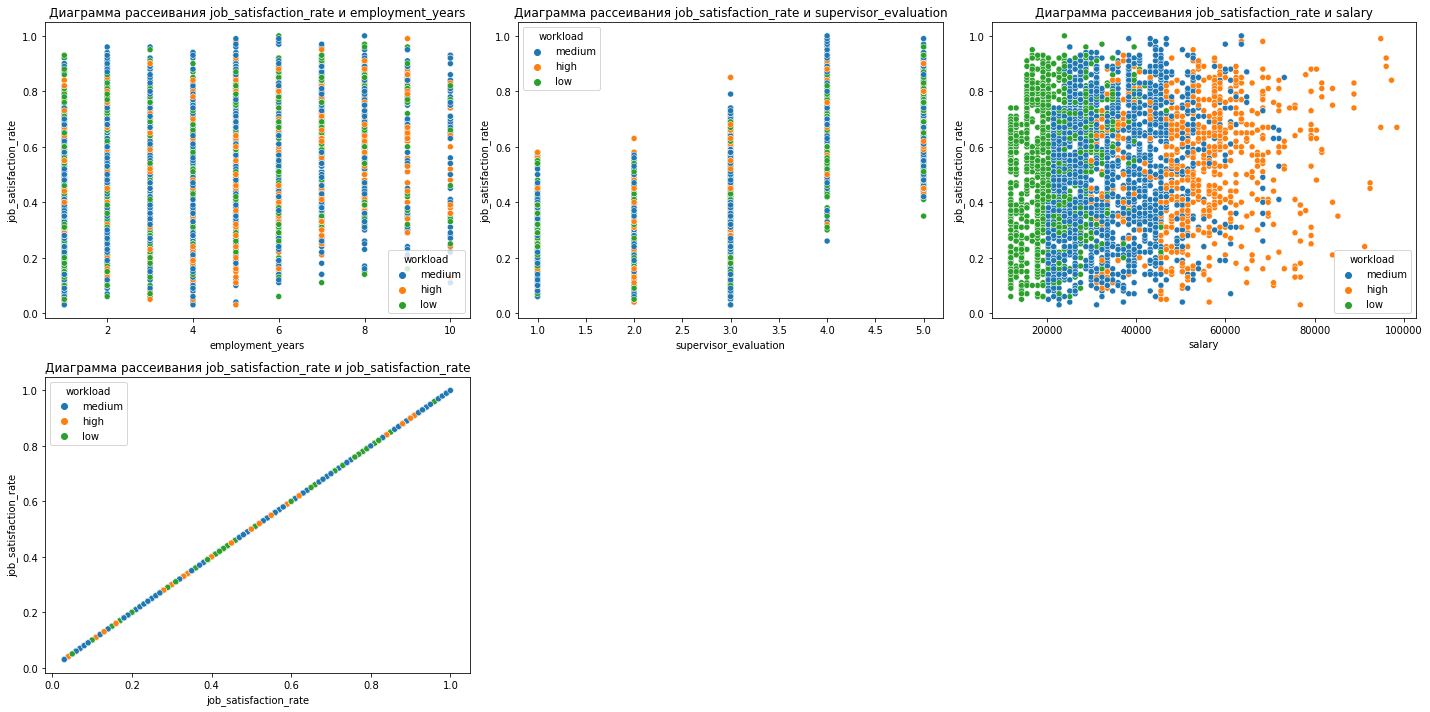

In [26]:
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=X_train_data, x=feature, y='job_satisfaction_rate', hue='workload')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

Визуализация не выявило явных зависимостей между workload — уровнем загруженности сотрудника и целевыйм признаком (job_satisfaction_rate)

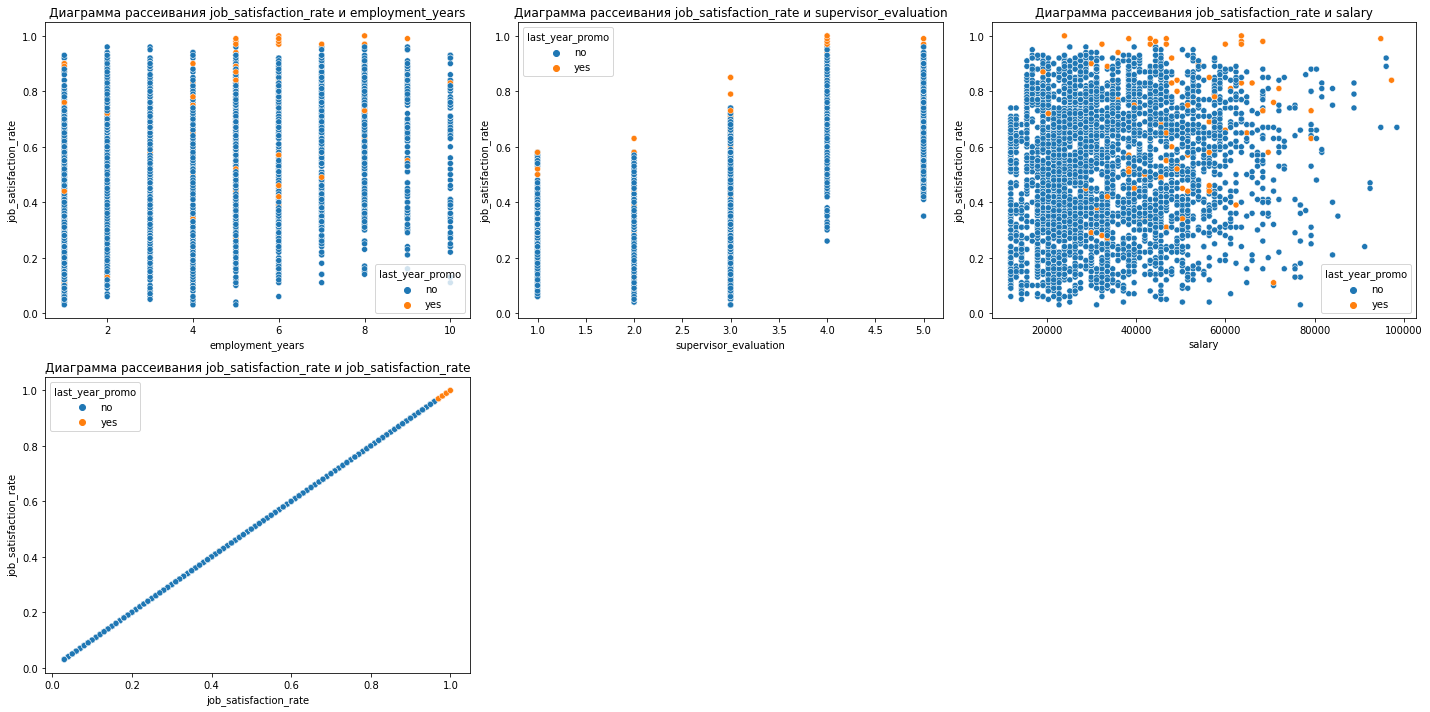

In [27]:
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=X_train_data, x=feature, y='job_satisfaction_rate', hue='last_year_promo')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

Выявлено что признак (last_year_promo) повышение в компании сильно влияет на удовлетворенность сотрудников (job_satisfaction_rate). Корреляционная матрица не уловило данную зависимость (0.19) ввиду незначительности данного признака, всего 3% сотрудников получили повышение. Зато визуализация количественых и категориальных признаков показала что данная зависимость есть.

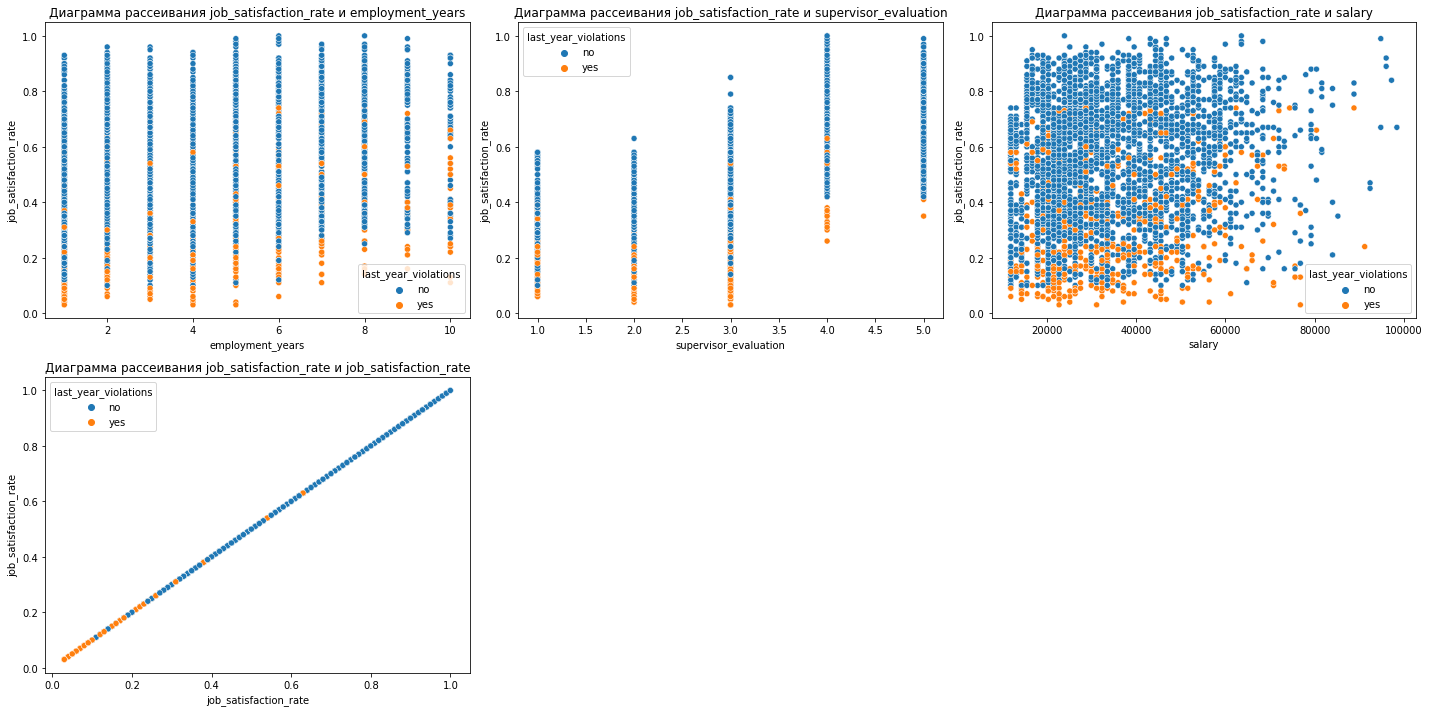

In [28]:
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=X_train_data, x=feature, y='job_satisfaction_rate', hue='last_year_violations')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

Признак (last_year_violations) — показывающий, нарушал ли сотрудник трудовой договор за последний год, имеет сильную корреляцию с признаком (job_satisfaction_rate) т.е сотрудник нарушавщий ТД как правило был не удовлетворен работой в компании.

<b>Вывод по исследовательскому анализу данных</b>
- Выявлены признаки которые хорошо коррелируют с целевым признаком (job_satisfaction_rate) это last_year_promo, last_year_violations и supervisor_evaluation. 

Остальные признаки не показали сильной корреляции с целевым признаком

<b>Исследовательский анализ тестовых данных</b>

In [29]:
test_data_for_corr = X_test_features_data.merge(y_test_data, on='id')

df_no_id = test_data_for_corr.drop(columns=['id'])

# Задаём список непрерывных переменных
interval_columns = [
    'salary',
    'job_satisfaction_rate',
]

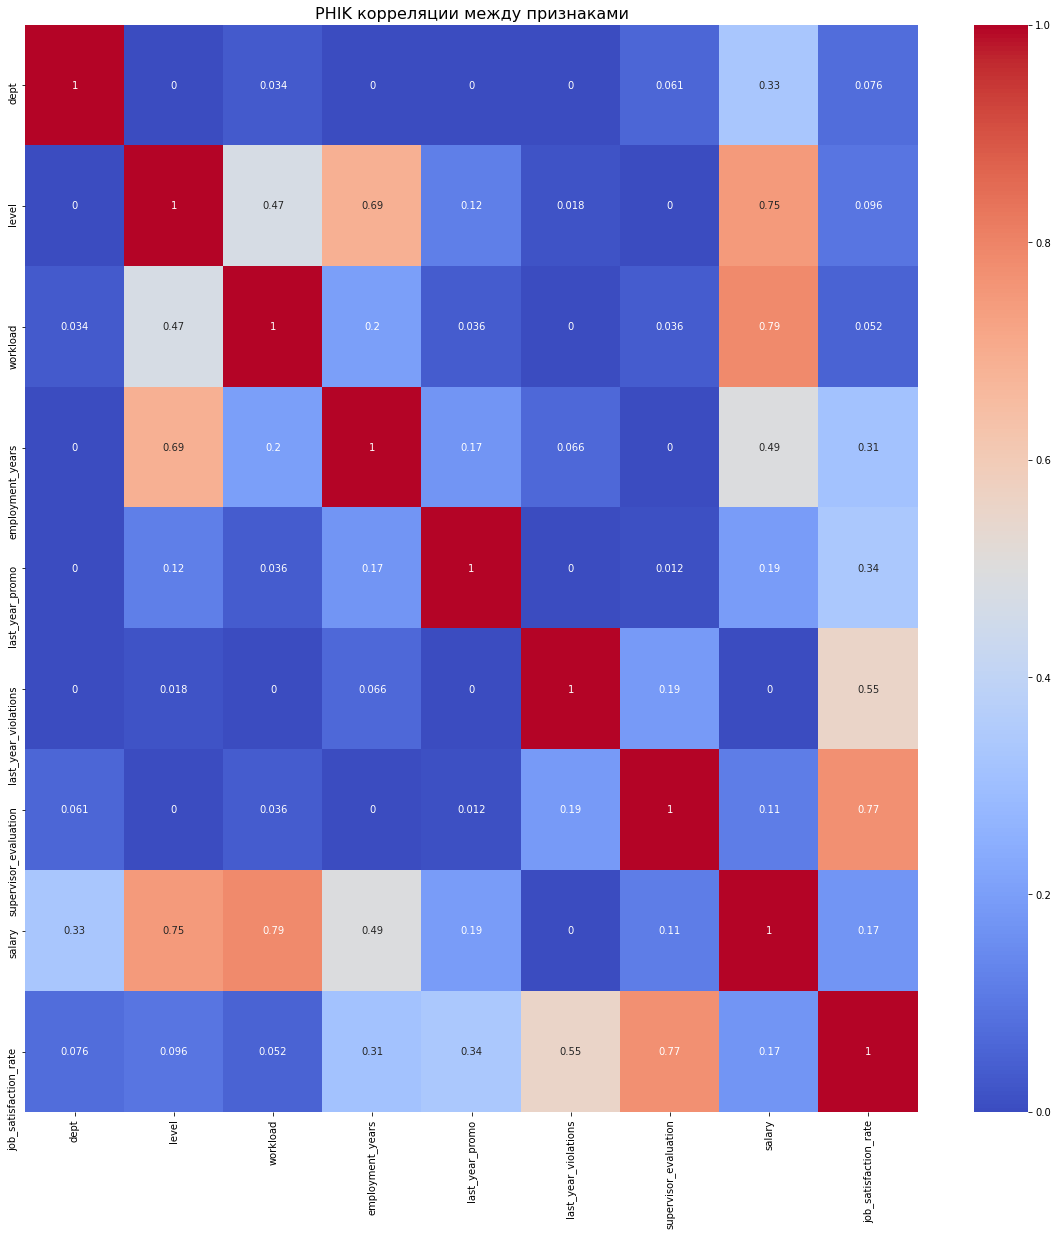

In [30]:
# Вычисляем phik-корреляции с указанием непрерывных переменных
phik_corr = df_no_id.phik_matrix(interval_cols=interval_columns)

# Визуализация
plt.figure(figsize=(20, 20))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm')
plt.title("PHIK корреляции между признаками", fontsize=16)
plt.show()

Матрица корреляции показала что тестовые данные не сильно отличаются от тренировочных, тем не менее отмечено что в тренировочных данных job_satisfaction_rate и last_year_promo имеют индекс корреляции 0.19 против тестовых 0.34. Разница в 0.15 пунктов наврятли скажется на качестве модели.

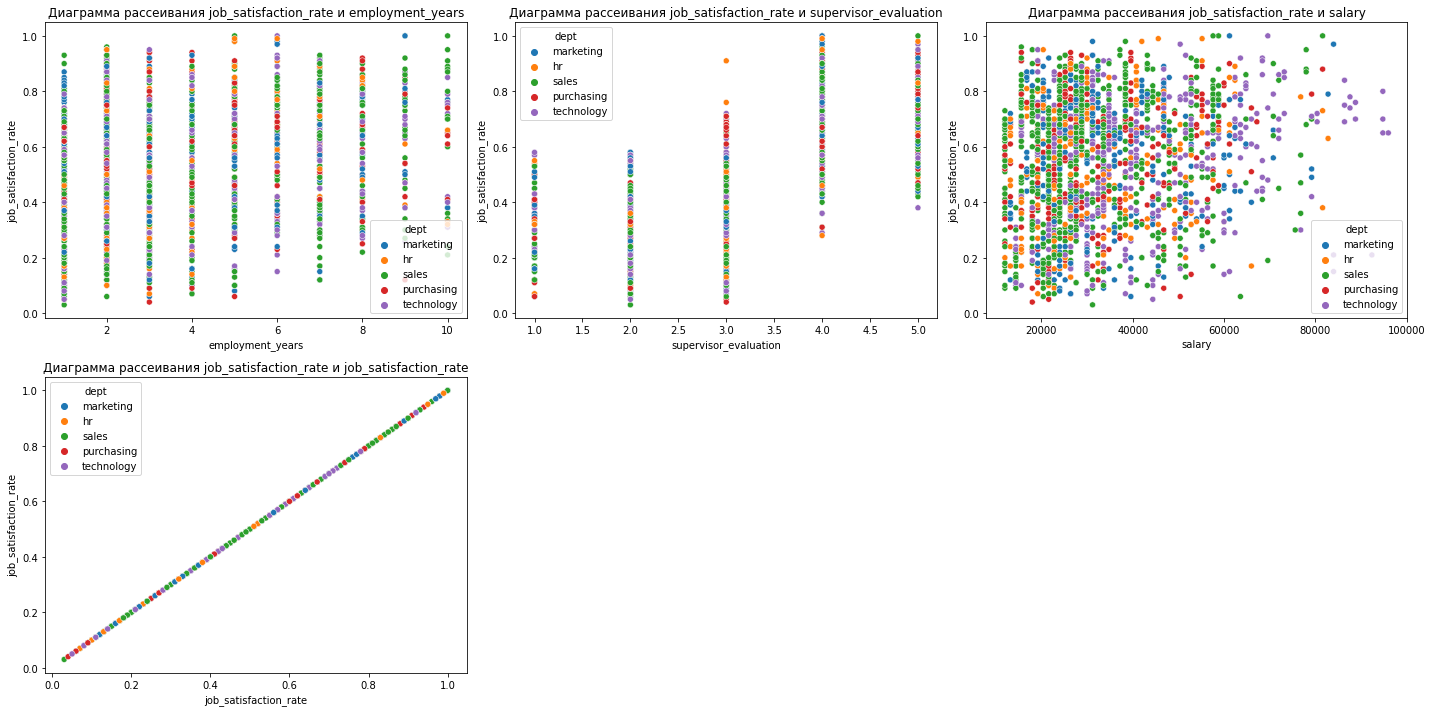

In [31]:
# Создадим список количественных признаков 
quantitative_array = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_no_id, x=feature, y='job_satisfaction_rate', hue='dept')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

- Анализ количественных и категориальных признаков тестовых данных показал что на удовлетворенность работой (job_satisfaction_rate) сильнее всего влияет (supervisor_evaluation) — т.е качества работы сотрудника, которую дал руководитель.

Отдел в котором работает сотрудник не показал какую либо зависимость с целевым признаком (job_satisfaction_rate)

- Данные имеют схожие распределения с тренировочной выборкой.

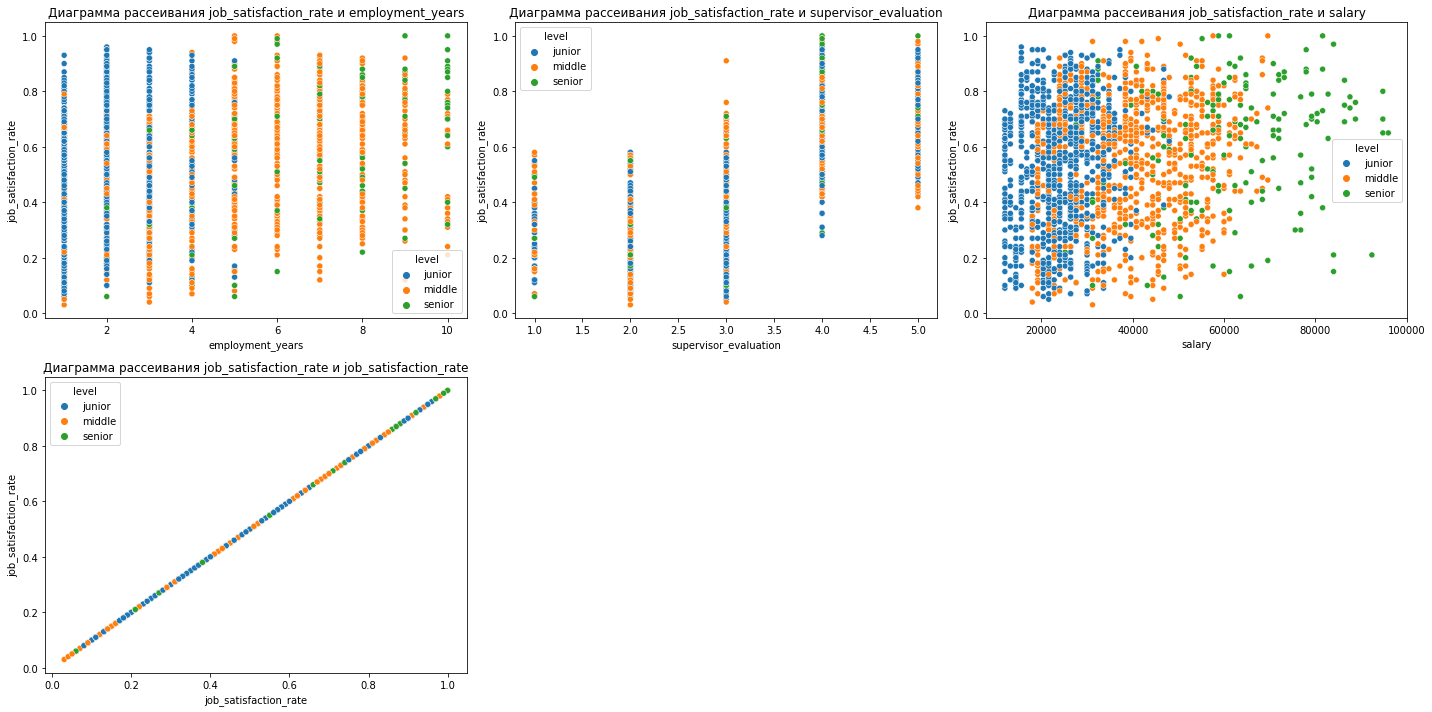

In [32]:
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_no_id, x=feature, y='job_satisfaction_rate', hue='level')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

Тестовые данные имеют схожую структуру в сравнении с тренировочными.
визуализация показала что все junior сотрудники работают в компании с основном от 1 года до 3, (реже до 4 лет), потом они уходят на повышение и их средняя оценка job_satisfaction_rate повышается.

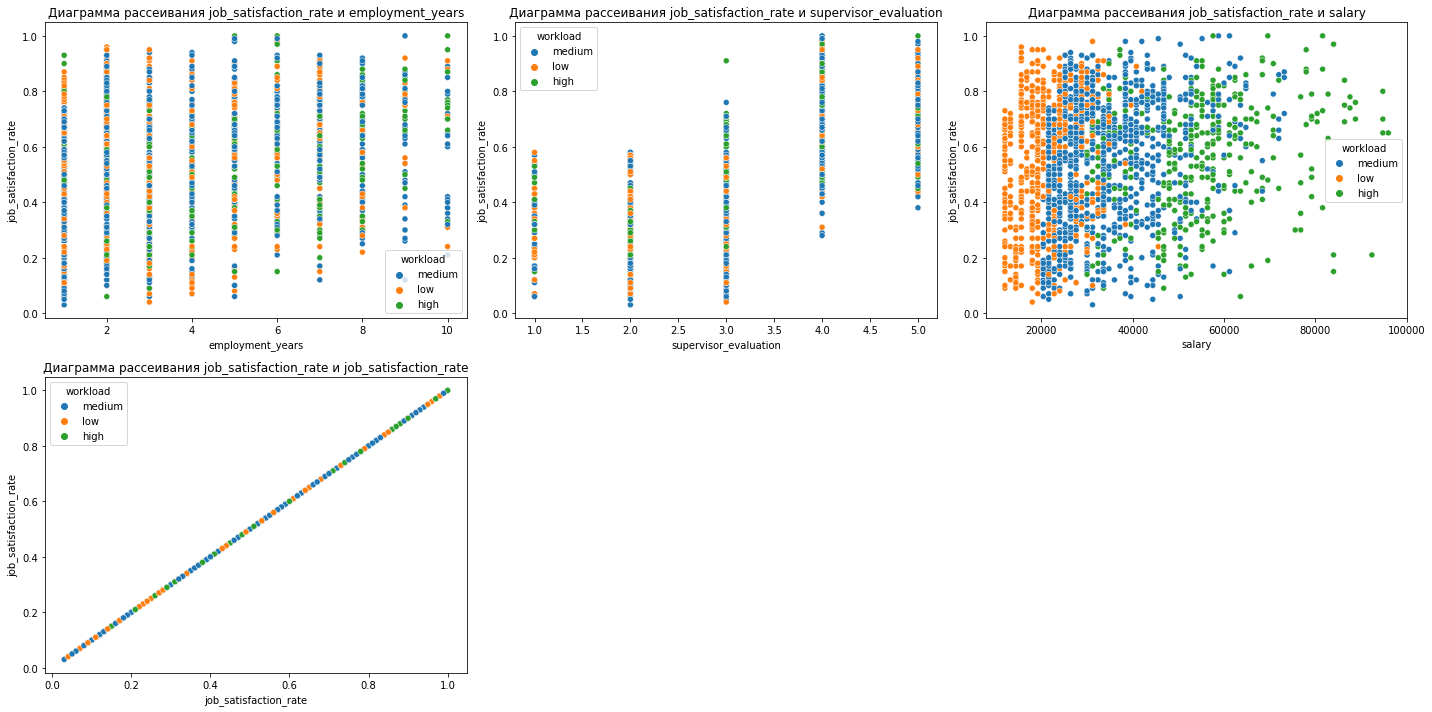

In [33]:
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_no_id, x=feature, y='job_satisfaction_rate', hue='workload')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

Визуализация не выявило явных различий между тестовыми и тренировочными данными. Данные имеют почти одинаковую структуру.

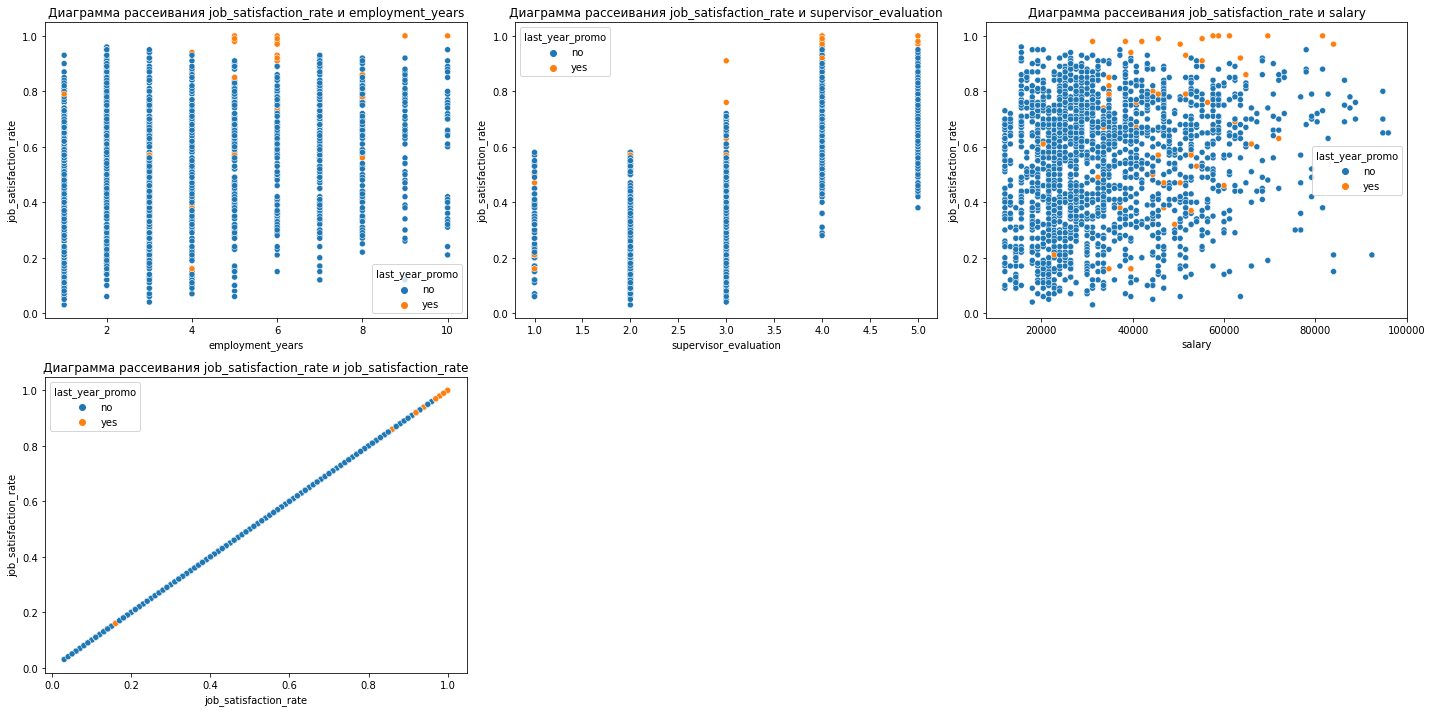

In [34]:
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_no_id, x=feature, y='job_satisfaction_rate', hue='last_year_promo')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

Как и в тренировочных данных выявлено что признак (last_year_promo) повышение в компании сильно влияет на удовлетворенность сотрудников (job_satisfaction_rate). Корреляционная матрица не уловило данную зависимость (0.19) ввиду незначительности данного признака, всего 3% сотрудников получили повышение. Зато визуализация количественых и категориальных признаков показала что данная зависимость есть.

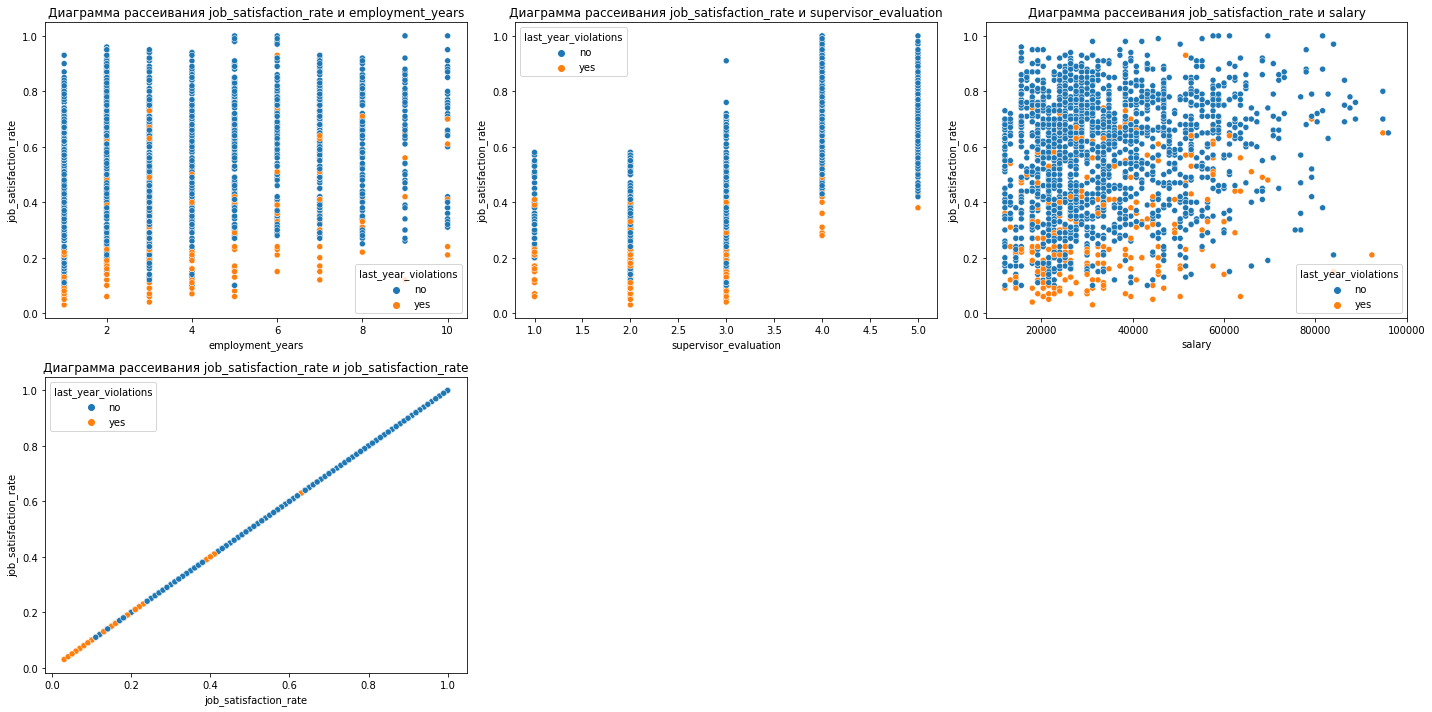

In [35]:
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_array, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_no_id, x=feature, y='job_satisfaction_rate', hue='last_year_violations')
    plt.title(f'Диаграмма рассеивания job_satisfaction_rate и {feature}')

plt.tight_layout()
plt.show()

Как и в тренировочных данных, признак (last_year_violations) — показывающий, нарушал ли сотрудник трудовой договор за последний год, имеет сильную корреляцию с признаком (job_satisfaction_rate) т.е сотрудник нарушавщий ТД как правило был не удовлетворен работой в компании.

<b>Подготовка данных для МО</b>

In [36]:
X_train = X_train_data.drop(['id'], axis=1)
print(check_duplicates(X_train_data, "X_train_data"))
X_train.shape

В X_train_data: 0 дубликатов
--------------------------------------------------
None


(4000, 9)

In [37]:
X_train = X_train_data.drop(['job_satisfaction_rate', 'id'], axis=1)
y_train = X_train_data['job_satisfaction_rate']
X_train.shape

(4000, 8)

In [38]:
test_data = X_test_features_data.merge(y_test_data, on='id')

In [39]:
X_test = test_data.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = test_data['job_satisfaction_rate']
X_test.shape

(2000, 8)

In [40]:
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation']
RANDOM_STATE = 42
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
     ],
    remainder='passthrough'
)

final_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [41]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # чтобы избежать деления на 0
    return np.mean(diff) * 100

smape_score = make_scorer(smape, greater_is_better=False)

In [42]:
models_and_parameters = [[
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],
    
    [{
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 21),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'models__n_estimators': range(10, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],

    [{
        'models': [KNeighborsRegressor(n_jobs=-1, weights='distance')],
        'models__n_neighbors': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],
]

In [43]:
best_cv_score = float('inf')
best_model = None
best_estimator = None

models = []
train_score = []
test_score = []

# Шаблон таблицы результатов
score_table = {
    'model': models,
    'train_SMAPE': train_score,
    'test_SMAPE': test_score,
}

# В цикле переберем по 30 комбинаций гиперпараметров для каждой модели и сохраним результаты в `score_table`
for grid in models_and_parameters:
    search = RandomizedSearchCV(
        final_pipeline,
        grid,
        n_jobs=-1,
        cv=5,
        n_iter=30,
        scoring=smape_score,
        random_state=RANDOM_STATE
    )

    search.fit(X_train, y_train)
    current_cv_score = (-1) * search.best_score_  # смотри, т.к. smape_score отрицательный

    models.append(search.best_estimator_['models'])
    train_score.append(current_cv_score)

    # Сохраняем лучшую модель по кросс-валидации
    if current_cv_score < best_cv_score:
        best_cv_score = current_cv_score
        best_model = search.best_estimator_['models']
        best_estimator = search.best_estimator_

        
        
# Оценим только лучшую модель на тесте
y_pred_test = best_estimator.predict(X_test)
test_smape = smape(y_test, y_pred_test)
test_score.append(test_smape)

print('Лучшая модель по кросс-валидации:')
print(best_model)
print('SMAPE на кросс-валидации (train):', best_cv_score)
print('SMAPE на тестовой выборке (test):', test_smape)

score_table = {
    'model': [best_model],
    'train_SMAPE': [best_cv_score],
    'test_SMAPE': [test_smape],
}

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель по кросс-валидации:
RandomForestRegressor(max_depth=20, min_samples_split=4, n_estimators=81,
                      random_state=42)
SMAPE на кросс-валидации (train): 13.278237177014015
SMAPE на тестовой выборке (test): 12.267828512524124


In [44]:
dummy = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])
dummy.fit(X_train, y_train)

y_dummy_pred = dummy.predict(X_test)
dummy_smape = smape(y_test, y_dummy_pred)
print(f"DummyClassifier_smape_score: {dummy_smape:.4f}")

DummyClassifier_smape_score: 37.5452


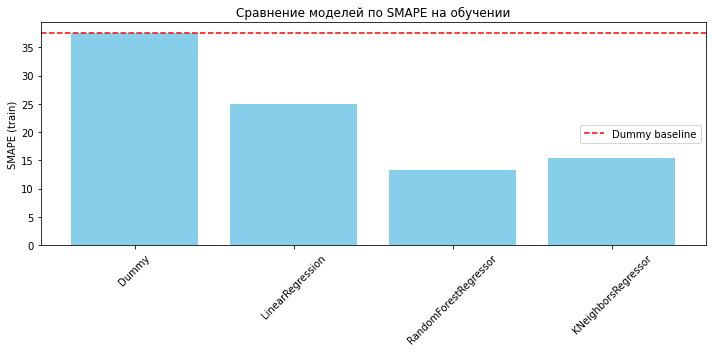

In [45]:
model_names = ['Dummy'] + [type(m).__name__ for m in models]
smape_scores = [dummy_smape] + train_score

plt.figure(figsize=(10, 5))
plt.bar(model_names, smape_scores, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('SMAPE (train)')
plt.title('Сравнение моделей по SMAPE на обучении')
plt.axhline(dummy_smape, color='red', linestyle='--', label='Dummy baseline')
plt.legend()
plt.tight_layout()
plt.show()

Визуализация показала что модель RandomForestRegressor более чем в два раза превосходит Dummy-классификатор. следовательно модель уловила взаимосвязь между данными.

<b>Вывод:</b>

- Лучшей моделью является: RandomForestRegressor, потому что:
Она показала наименьшее SMAPE как на обучении, так и на тесте.

- Обгоняет KNN примерно на 2% SMAPE.

- Значительно лучше линейной регрессии (разница почти вдвое).

<b>Задача № 2</b>
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [46]:
X_train_quit = pd.read_csv('/datasets/train_quit.csv')
X_test_features = pd.read_csv('/datasets/test_features.csv')
y_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [47]:
def pretty_display(df, title="Таблица"):
    styled_df = df.head(5).style \
        .set_table_styles(
            [{'selector': 'th', 'props': [('text-align', 'center')]}]
        ) \
        .set_properties(**{'text-align': 'center'}) \
        .highlight_null(null_color='lightgray') \
        .set_caption(title)
    
    display(styled_df)
    
pretty_display(X_train_quit, "Первые 5 строк таблицы X_train_quit")
pretty_display(X_test_features, "Первые 5 строк таблицы X_test_features")
pretty_display(y_test_target_quit, "Первые 5 строк таблицы y_test_target_quit")

Нет никаких различий в структуре исходных данных.

<b>Проверка файлов на наличие дубликатов</b>

In [48]:
def check_duplicates(df, name):
    dup_count = df.duplicated().sum()
    print(f"В {name}: {dup_count} дубликатов")
    if dup_count > 0:
        print(df[df.duplicated()].head())
    print('-' * 50)

In [49]:
X_train_quit_missing_values = X_train_quit.isnull().sum()
X_train_quit_missing_values = X_train_quit_missing_values[X_train_quit_missing_values > 0].sort_values(ascending=False)
X_train_quit_missing_values
check_duplicates(X_train_quit, "X_train_quit")
X_train_quit = X_train_quit.drop_duplicates().reset_index(drop=True)

В X_train_quit: 0 дубликатов
--------------------------------------------------


In [50]:
X_test_features_missing_values = X_test_features.isnull().sum()
X_test_features_missing_values = X_test_features_missing_values[X_test_features_missing_values > 0].sort_values(ascending=False)
X_test_features_missing_values
check_duplicates(X_test_features, "X_test_features")
X_test_features = X_test_features.drop_duplicates().reset_index(drop=True)

В X_test_features: 0 дубликатов
--------------------------------------------------


In [51]:
y_test_target_quit_missing_values = y_test_target_quit.isnull().sum()
y_test_target_quit_missing_values = y_test_target_quit_missing_values[y_test_target_quit_missing_values > 0].sort_values(ascending=False)
y_test_target_quit_missing_values
check_duplicates(y_test_target_quit, "y_test_target_quit")
y_test_target_quit = y_test_target_quit.drop_duplicates().reset_index(drop=True)

В y_test_target_quit: 0 дубликатов
--------------------------------------------------


In [52]:
display(X_train_quit.info())
display(X_test_features.info())
display(y_test_target_quit.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

Проверка на наличие явных дубликатов показала что данные не содержат явных дубликатов. Столюцы имеют нормальные типы.

<b>Проверка файлов на наличие пропусков</b>

In [53]:
print(X_train_quit.isnull().sum())
print(X_test_features.isnull().sum())
print(y_test_target_quit.isnull().sum())

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
id      0
quit    0
dtype: int64


In [54]:
unique_values_dict = {
    column: list(X_train_quit[column].unique())
    for column in X_train_quit.columns
    if X_train_quit[column].dtype == 'object'
}
print(unique_values_dict)

{'dept': ['sales', 'purchasing', 'marketing', 'technology', 'hr'], 'level': ['middle', 'junior', 'sinior'], 'workload': ['high', 'medium', 'low'], 'last_year_promo': ['no', 'yes'], 'last_year_violations': ['no', 'yes'], 'quit': ['no', 'yes']}


In [55]:
X_train_quit['level'].replace({'sinior': 'senior'}, inplace=True)
print(X_train_quit['level'].unique())

['middle' 'junior' 'senior']


In [56]:
unique_values_dict = {
    column: list(X_test_features[column].unique())
    for column in X_test_features.columns
    if X_test_features[column].dtype == 'object'
}
print(unique_values_dict)

{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '], 'level': ['junior', 'middle', 'sinior', nan], 'workload': ['medium', 'low', 'high', ' '], 'last_year_promo': ['no', 'yes'], 'last_year_violations': ['no', 'yes']}


In [57]:
X_test_features['level'].replace({'sinior': 'senior'}, inplace=True)
X_test_features['dept'].replace({' ': np.nan}, inplace=True)
X_test_features['workload'].replace({' ': np.nan}, inplace=True)

In [58]:
unique_values_dict = {
    column: list(X_test_features[column].unique())
    for column in X_test_features.columns
    if X_test_features[column].dtype == 'object'
}
print(unique_values_dict)

{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan], 'level': ['junior', 'middle', 'senior', nan], 'workload': ['medium', 'low', 'high', nan], 'last_year_promo': ['no', 'yes'], 'last_year_violations': ['no', 'yes']}


In [59]:
y_test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

<b>Вывод по предобработке данных</b>
- В столбцах level файлах train_quit.csv и test_features.csv обнаружена такая же орфографическая ошибка как и в первой задаче. проведена аналогичная работа по исправление данных.

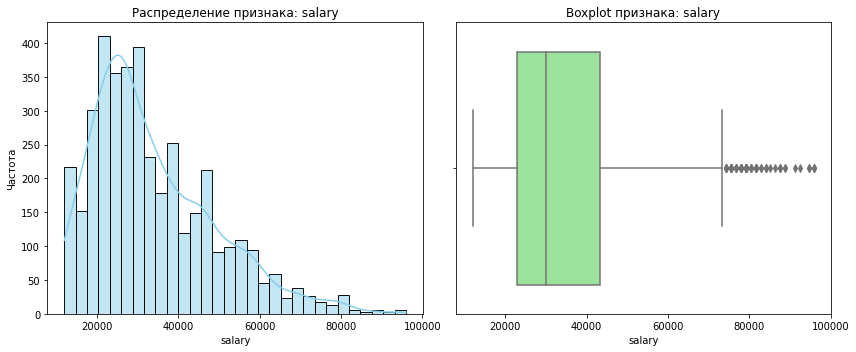

In [60]:
X_train_quit_with_no_id = X_train_quit.drop(['id', 'employment_years', 'supervisor_evaluation'], axis=1)
plot_numeric_features(X_train_quit_with_no_id)

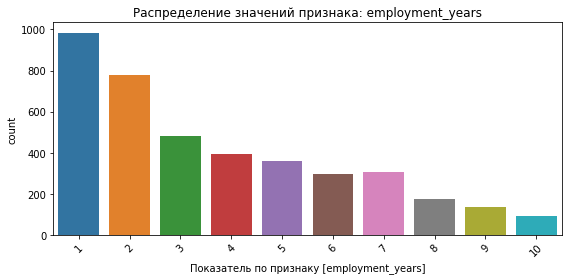

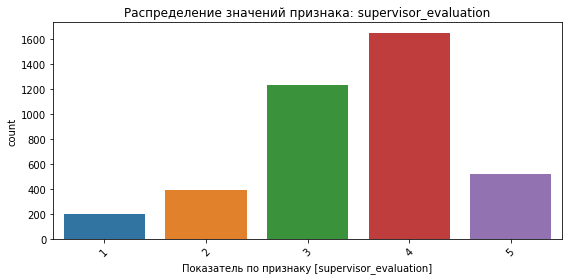

In [61]:
X_train_quit_with_no_id = X_train_quit.drop(['id'], axis=1)
def plot_countplots(df, columns, figsize=(8, 4)):
    for col in columns:
        plt.figure(figsize=figsize)
        sns.countplot(x=df[col])
        plt.xlabel(f'Показатель по признаку [{col}]')
        plt.title(f'Распределение значений признака: {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
columns_to_plot = [
    'employment_years',
    'supervisor_evaluation'
]

plot_countplots(X_train_quit_with_no_id, columns_to_plot)

Данные не отличаются от первых, кроме как отсутствия значения job_satisfaction_rate. данные не требуют удаления аномальных значений.

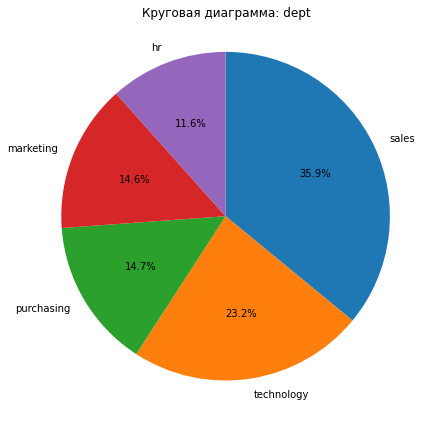

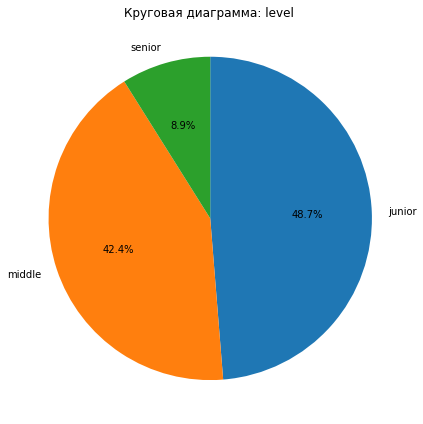

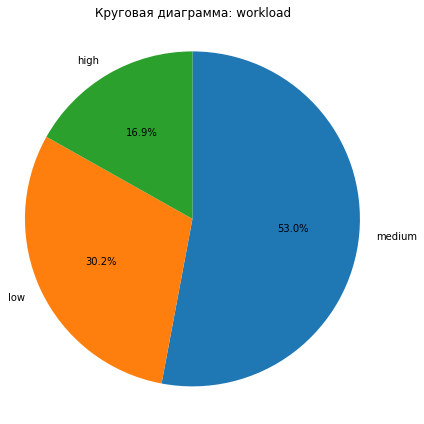

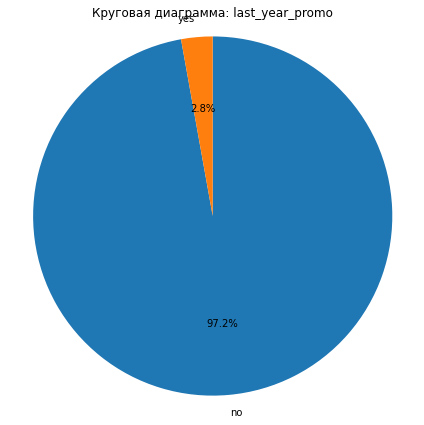

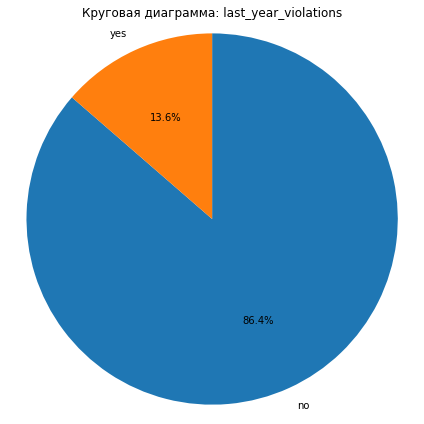

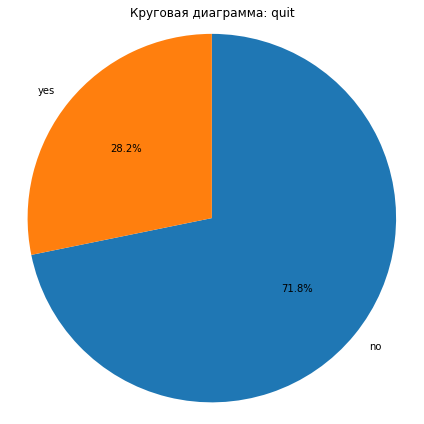

In [62]:
plot_categorical_pie_charts(X_train_quit_with_no_id)

- Визуализация категориальных признаков показало что некоторые столбцы имеют дисбаланс значений, last_year_violations, last_year_promo и quit. В целом при подготовке данных к обучения стоит учесть несбалансированность признаков.

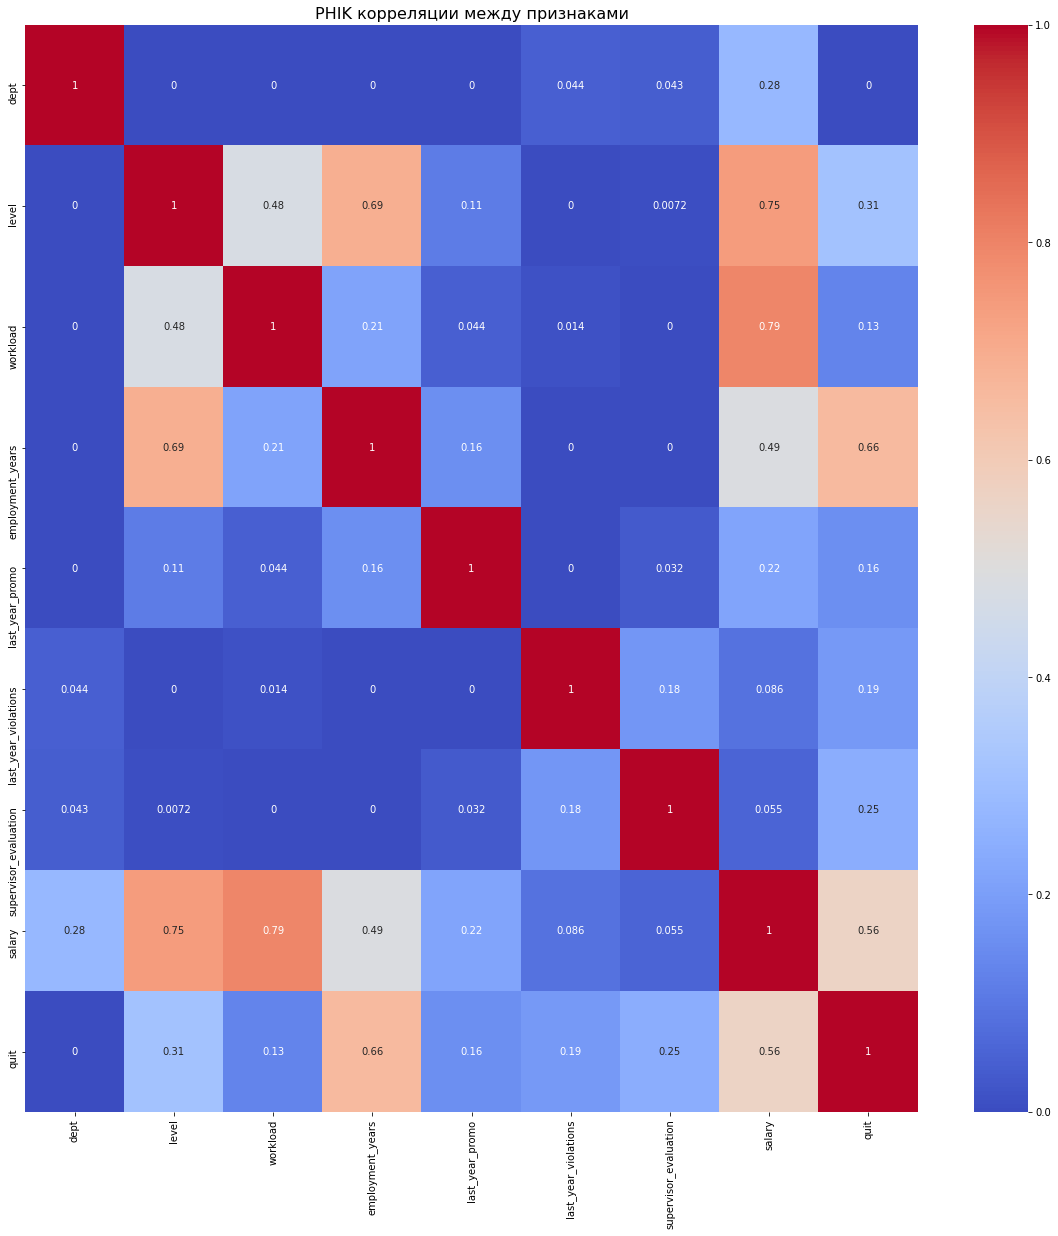

In [63]:
df_no_id = X_train_quit.drop(columns=['id'])

# Задаём список непрерывных переменных
interval_columns = [
    'salary'
   ]

# Вычисляем phik-корреляции с указанием непрерывных переменных
phik_corr = df_no_id.phik_matrix(interval_cols=interval_columns)

# Визуализация
plt.figure(figsize=(20, 20))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm')
plt.title("PHIK корреляции между признаками", fontsize=16)
plt.show()

Матрица показала что больше всего коррелирует с целевым признаком (quit):
- employment_years — длительность работы в компании (в годах) - 0,66
- salary — ежемесячная зарплата сотрудника - 0,56
- level — уровень занимаемой должности - 0,31
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель - 0,25

<b>Портрет уволившегося сотрудника</b>

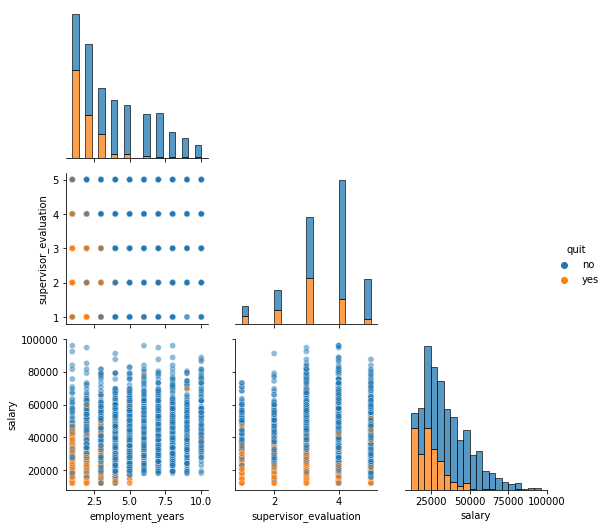

In [64]:
# Построим графики зависимостей признаков
data = sns.PairGrid(X_train_quit.drop(columns=['id']), diag_sharey=False, corner=True, hue='quit')
data.map_lower(sns.scatterplot, alpha=0.5)
data.map_diag(sns.histplot, multiple="stack", bins=20)
data.add_legend()
plt.show()

In [65]:
quit = X_train_quit.query('quit == "yes"')
not_quit = X_train_quit.query('quit == "no"')

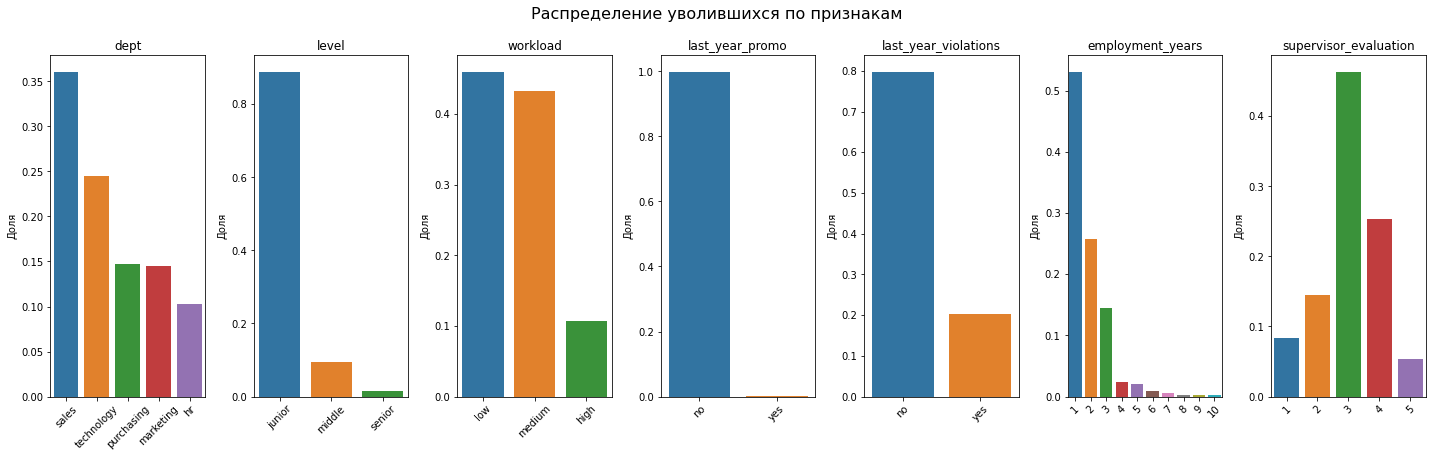

In [66]:
categorical_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'employment_years', 'supervisor_evaluation']

fig, axes = plt.subplots(nrows=1, ncols=len(categorical_cols), figsize=(20, 6))

# Для каждого признака — отдельный subplot
for i, col in enumerate(categorical_cols):
    data = quit[col].value_counts(normalize=True)
    sns.barplot(
        x=data.index,
        y=data.values,
        ax=axes[i]
    )
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Доля')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Распределение уволившихся по признакам', y=1.05, fontsize=16)
plt.show()

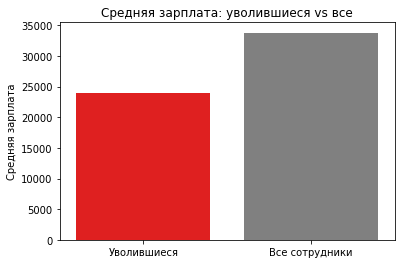

In [67]:
avg_salary_resigned = quit['salary'].mean()
avg_salary_all = X_train_quit['salary'].mean()

plt.figure()
sns.barplot(
    x=['Уволившиеся', 'Все сотрудники'],
    y=[avg_salary_resigned, avg_salary_all],
    palette=['red', 'grey']
)
plt.title('Средняя зарплата: уволившиеся vs все')
plt.ylabel('Средняя зарплата')
plt.show()

<b>Портрет "уволившегося сотрудника"</b>
- Диаграмма хорошо показывает что больше всего увольняются сотрудники juniour уровня.
- Лидирующую позицию занимает отдел sales и technology.
- Такой сотрудник имеет низкую или среднюю загруженность
- Практически всегда не получает повышение в компании
- Работает в компании сравнительно недавно
- Имеет в среднем низкую заработную плату.

In [68]:
target = y_test_data.merge(y_test_target_quit, on='id', how='left')
target=target.set_index('id')
target.head()

job_satisfaction_rate quit
id                                
130604                   0.74   no
825977                   0.75   no
418490                   0.60  yes
555320                   0.72   no
826430                   0.08  yes

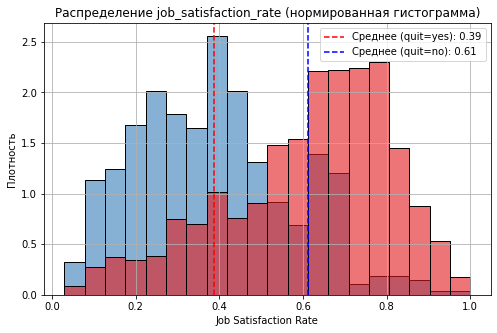

In [69]:
mean_yes = target[target['quit'] == 'yes']['job_satisfaction_rate'].mean()
mean_no = target[target['quit'] == 'no']['job_satisfaction_rate'].mean()

plt.figure(figsize=(8, 5))
sns.histplot(data=target, x='job_satisfaction_rate', hue='quit',
             stat='density', common_norm=False, bins=20, palette='Set1', alpha=0.6)

# Вертикальные линии среднего
plt.axvline(mean_yes, color='red', linestyle='--', label=f'Среднее (quit=yes): {mean_yes:.2f}')
plt.axvline(mean_no, color='blue', linestyle='--', label=f'Среднее (quit=no): {mean_no:.2f}')

plt.title('Распределение job_satisfaction_rate (нормированная гистограмма)')
plt.xlabel('Job Satisfaction Rate')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

Гистограмма показвает что у тех сотрудников которые уволились job_satisfaction_rate равен 0.39 против 0.61 у тех кто остался.

<b>Нулевая гипотеза (H0):</b>Среднее значение job_satisfaction_rate одинаково у уволившихся и неуволившихся сотрудников.

<b>Альтернативная гипотеза (H₁):</b>Средние значения различаются.

In [70]:
satisfaction_yes = target[target['quit'] == 'yes']['job_satisfaction_rate']
satisfaction_no = target[target['quit'] == 'no']['job_satisfaction_rate']

# t-тест для независимых выборок
t_stat, p_value = ttest_ind(satisfaction_yes, satisfaction_no, equal_var=False)

print(f"T-статистика: {t_stat:.3f}")
print(f"P-значение: {p_value:.4f}")

T-статистика: -23.795
P-значение: 0.0000


Сотрудники которые уволились имели значимо более низкий уровень удовлетворенности работой, чем те, кто остался.
Это статистически подтверждено: различия между группами значимы (p < 0.0001).

<b>Добавление новых признаков</b>

In [71]:
X_test_features['job_satisfaction_rate_prediction'] = search.best_estimator_.predict(X_test_features_data)

# Показываем первые строки с предсказаниями
display(X_test_features.head())

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  \
0                   no                      5   28800   
1                   no                      4   30000   
2                   no                      4   19200   
3                   no                      4   19200   
4                   no                      5   40800   

   job_satisfaction_rate_prediction  
0                          0.866667  
1                          0.678333  
2                          0.656667  
3                          0.655000  
4                          0.760000

In [72]:
X_train_quit['job_satisfaction_rate_prediction'] = search.best_estimator_.predict(X_train_quit.drop(['quit'], axis=1))
X_train_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      4   54000   no   
1                   no                      4   27600   no   
2                   no                      1   37200   no   
3                  yes                      3   24000  yes   
4                   no                      5   25200   no   

   job_satisfaction_rate_prediction  
0                          0.572727  
1                          0.836667  
2                          0.319980  
3                          0.380000  
4                          0.690000

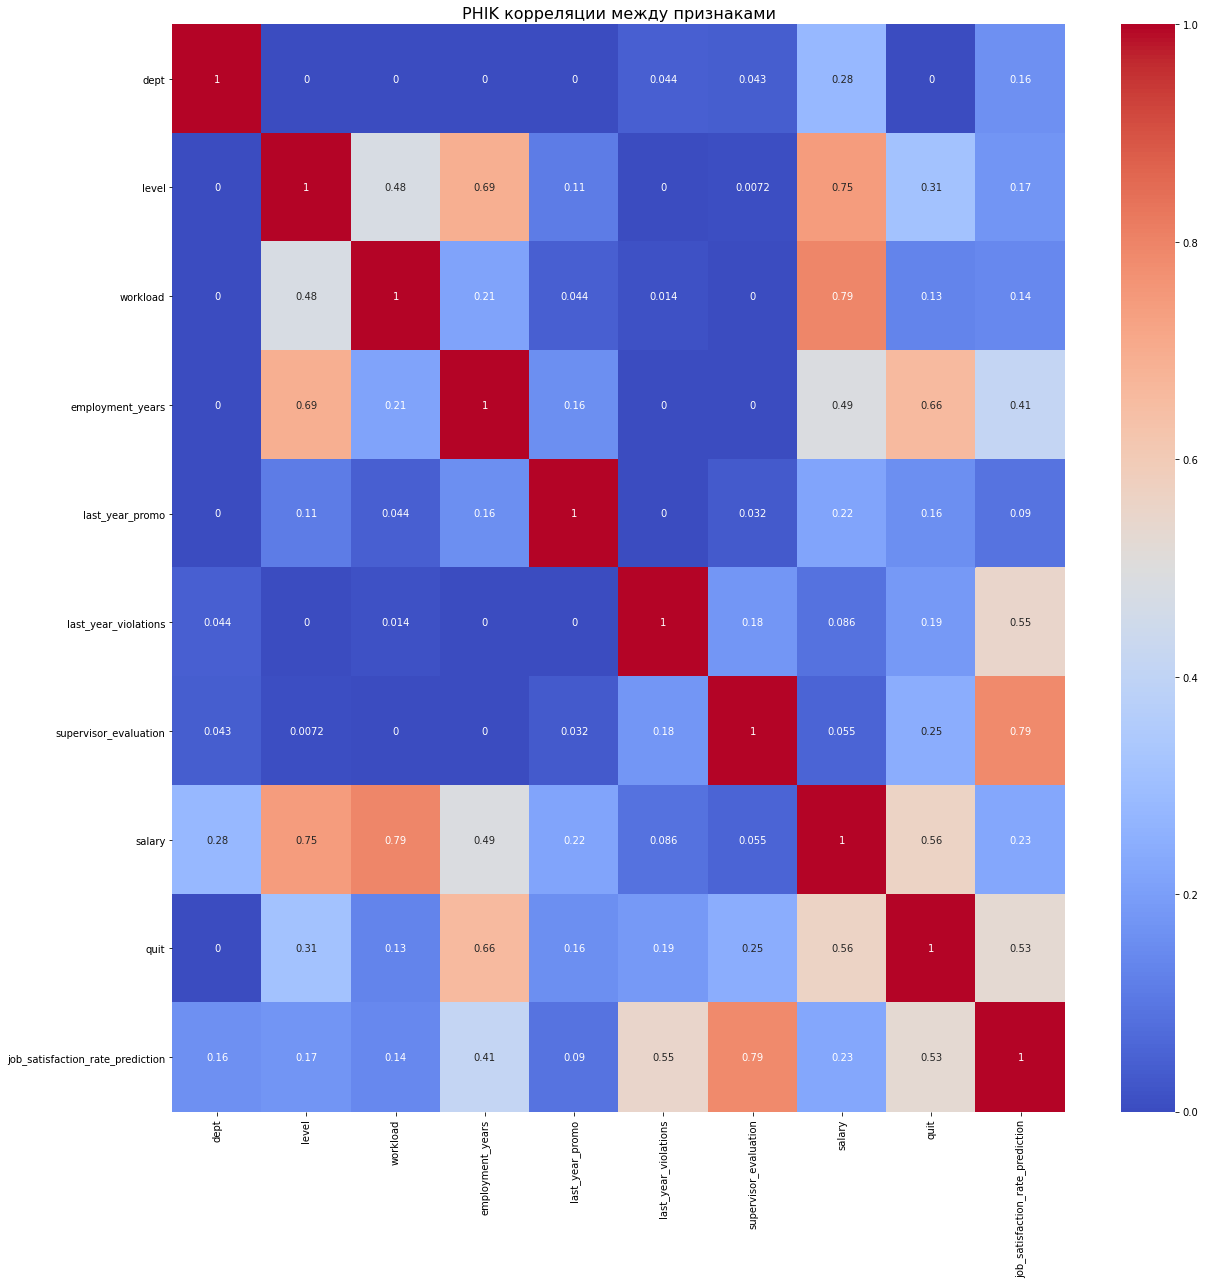

In [73]:
df_no_id = X_train_quit.drop(columns=['id'])

# Задаём список непрерывных переменных
interval_columns = [
    'salary',
    'job_satisfaction_rate_prediction'
   ]

# Вычисляем phik-корреляции с указанием непрерывных переменных
phik_corr = df_no_id.phik_matrix(interval_cols=interval_columns)

# Визуализация
plt.figure(figsize=(20, 20))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm')
plt.title("PHIK корреляции между признаками", fontsize=16)
plt.show()

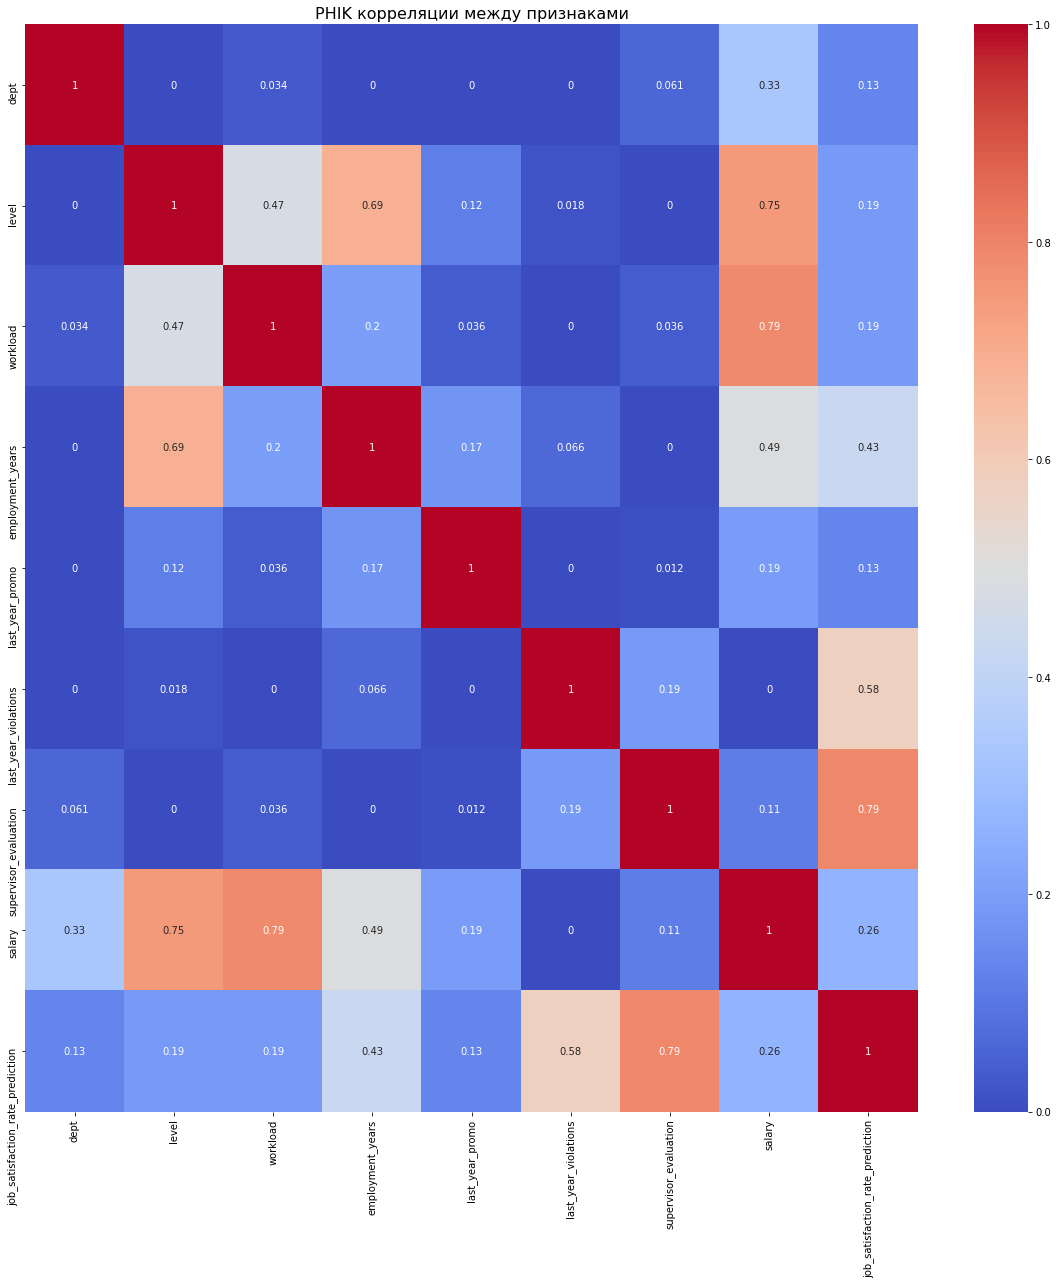

In [74]:
df_no_id = X_test_features.drop(columns=['id'])

# Задаём список непрерывных переменных
interval_columns = [
    'salary',
    'job_satisfaction_rate_prediction'
   ]

# Вычисляем phik-корреляции с указанием непрерывных переменных
phik_corr = df_no_id.phik_matrix(interval_cols=interval_columns)

# Визуализация
plt.figure(figsize=(20, 20))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm')
plt.title("PHIK корреляции между признаками", fontsize=16)
plt.show()

На основе предоставленной матрицы корреляции PHIK коэффициент корреляции между признаками quit и job_satisfaction_rate_prediction незначителен.

<b>Вывод</b>
- Получилось предсказать признак job_satisfaction_rate в тестовых данных и тренировочных данных.

<b>Подготовка данных</b>

In [75]:
X_train_quit_ml = X_train_quit.drop(['quit', 'id'], axis=1)
y_train_ml = X_train_quit['quit']
X_train_quit_ml.shape

(4000, 9)

In [76]:
test = X_test_features.merge(y_test_target_quit, on='id')
X_test_quit_ml = test.drop(['quit', 'id'], axis=1)
y_test_ml = test['quit']
X_test_quit_ml.shape

(2000, 9)

In [77]:
label_encoder = LabelEncoder()

label_encoder.fit(y_train_ml)

# Затем трансформируем
y_train_ml = label_encoder.transform(y_train_ml)
y_test_ml = label_encoder.transform(y_test_ml)

In [78]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 

final_pipeline2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [79]:
# ROC-AUC требует вероятности
roc_auc = 'roc_auc'

models_and_parameters = [[
    {
        'models': [LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],
    
    [{
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 21),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'models__n_estimators': range(10, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],

    [{
        'models': [KNeighborsClassifier(n_jobs=-1, weights='distance')],
        'models__n_neighbors': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }],
]

In [80]:
models = []
train_scores = []
test_scores = []
best_model = None
best_score = -1  # AUC-ROC может быть от 0 до 1, поэтому инициализируем -1

for grid in models_and_parameters:
    search = RandomizedSearchCV(
        final_pipeline,
        grid,
        n_jobs=-1,
        cv=10,
        n_iter=30,
        scoring='roc_auc',  # Убедитесь, что передана строка или scoring-функция
        random_state=RANDOM_STATE
    )

    search.fit(X_train_quit_ml, y_train_ml)
    current_model = search.best_estimator_['models']
    current_train_score = search.best_score_

    # Сохраняем модель, если она лучше предыдущих
    if current_train_score > best_score:
        best_model = search.best_estimator_
        best_score = current_train_score

    print(current_model)
    print('AUC-ROC лучшей модели на кросс-валидации:', current_train_score)
    print('---')

    models.append(current_model)
    train_scores.append(current_train_score)

# Оцениваем только лучшую модель на тестовой выборке
if best_model is not None:
    test_predictions_proba = best_model.predict_proba(X_test_quit_ml)[:, 1]
    final_test_score = roc_auc_score(y_test_ml, test_predictions_proba)
    
    print("Лучшая модель по кросс-валидации:", best_model['models'])
    print("AUC-ROC на кросс-валидации:", best_score)
    print(f"AUC-ROC на тестовой выборке: {final_test_score}")
else:
    print("Не удалось обучить ни одну модель.")


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


LogisticRegression(max_iter=1000, random_state=42)
AUC-ROC лучшей модели на кросс-валидации: 0.9174942446739405
---
RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=50,
                       random_state=42)
AUC-ROC лучшей модели на кросс-валидации: 0.9401515695387579
---
KNeighborsClassifier(n_jobs=-1, n_neighbors=9, weights='distance')
AUC-ROC лучшей модели на кросс-валидации: 0.9069384715850288
---
Лучшая модель по кросс-валидации: RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=50,
                       random_state=42)
AUC-ROC на кросс-валидации: 0.9401515695387579
AUC-ROC на тестовой выборке: 0.9284020081392363


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<b>Вывод</b>
- Лучше модель для предсказания увольнения сотрудника является RandomForestClassifier с гиперпараметрами (max_depth=9, min_samples_split=5, n_estimators=50, random_state=42).
- Лучший AUC-ROC на кросс-валидации: 0,94
- AUC-ROC на тестовой выборке: 0,93

In [81]:
dummy_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DummyClassifier(strategy='most_frequent')) 
])

dummy_pipeline.fit(X_train_quit_ml, y_train_ml)

dummy_proba = dummy_pipeline.predict_proba(X_test_quit_ml)[:, 1]

dummy_roc_auc = roc_auc_score(y_test_ml, dummy_proba)

print(f"DummyClassifier ROC-AUC: {dummy_roc_auc:.4f}")

DummyClassifier ROC-AUC: 0.5000


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


DummyClassifier показал значения ROC-AUC - 0.5, то есть просто угадал между бинарным признаком "quit",

<b>Итоги</b>

Была проведена большая работа по созданию двух моделей, первая предсказывала уровень удовлетворенности клиента на основе предоставленных данных. Для выполнения задачи были проведены следующие действия:

<b>1) Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.</b>

- загрузка данных

- проверка типов на соответствия

- обработка данных, удаление дубликатов и пропусков, исправление орфографических ошибок

- исследовательский анализ данных категориальных и количественных признаков

- визуализация коррелирующих признаков

- подготоква пайплайна для кодирования и маштабирования признаков

- отобрали три модели для предсказания целевого признака (LinearRegression, RandomForestRegressor, KNeighborsRegressor)

- обучение моделей и выбор лучшего на основе метрики SMAPE

Параметры лучшей метрики: 
RandomForestRegressor(max_depth=20, min_samples_split=4, n_estimators=81, random_state=42)

SMAPE лучшей модели на кросс-валидации по обучающей выборке: 13.08

SMAPE на тестовой выборке: 12.24

<b>2) Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.</b>

- загрузка данных
- проверка типов на соответствия

- обработка данных, удаление дубликатов и пропусков, исправление орфографических ошибок

- исселдовательский анализ данных категориальных и количественных признаков

- визуализация коррелирующих признаков

- на основе лучшей модели добавление новызх признаков во второй набор обучающих данных (job_satisfaction_rate_predictionь, quit)

- подготоква пайплайна для кодирования и маштабирования признаков

- отобрали три модели для предсказания целевого признака (LogisticRegression, RandomForestRegressor, KNeighborsRegressor)

- обучение моделей и выбор лучшего на основе метрики roc_auc

Параметры лучшей модели: 

RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=50,random_state=42)

AUC-ROC лучшей модели на кросс-валидации по обучающей выборке: 0.939

AUC-ROC на тестовой выборке: 0.929

<b>Рекомендации заказчику</b>

- Отмечено что решающую роль на удовлетворенность сотрудника работой влиют следующие признаки: Оценка руководителя работой подчиненного, позиция работника, младшие сотрудники без перспектив повышения уходят с работы, уровень загруженности работой и заработная плата.

Следовательно что бы сотрудники не увольнялись следует загружать их работой и повышать по должности по мере возможности.